In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
path='./MNIST_data'

mnist_data = datasets.MNIST(path, download=True, transform=transforms.ToTensor()).train_data.float()
train_mean = mnist_data.mean() / 255
train_std = mnist_data.std() / 255

mnist_sigm = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((train_mean,), (train_std,)),
                lambda x: x.to(device)
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_sigm)

In [5]:
train_data = datasets.MNIST('./MNIST_data', download=True, transform=mnist_sigm)
im = [train_data[i][0] for i in range(len(mnist_data))]
trdata = torch.stack(im).float()
print ("Transformed data mean: {:.8}".format(trdata.mean()))
print ("Transformed data std: {:.8}".format(trdata.std()))

Transformed data mean: -1.9292506e-07
Transformed data std: 1.0


In [6]:
def get_random_h():
    z = torch.randn((50, 10))     
    return z

In [7]:
train_epoch = 500
batch_size = 50
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [8]:
fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data.to(device)
fixed_h = get_random_h().to(device)

In [9]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), stride=1, device='cpu'):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), output_padding=0, device='cpu'):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [11]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Sigmoid(), flatten=False, last_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [12]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', device='cpu', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 10
        
        self._conv1 = ConvLayer([1, 32, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv2 = ConvLayer([32, 64, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv3 = ConvLayer([64, 64, 3], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        
        self.latent_fn = nn.Sigmoid()
                    
        self.fce = FullyConnected([64*2*2, self.latent_size])
        self.fcd = FullyConnected([self.latent_size, 64*2*2])
        
        self._deconv1 = DeconvLayer([64, 64, 3], stride=2, padding=0, bn=batchnorm, device=device)
        self._deconv2 = DeconvLayer([64, 32, 4], stride=2, padding=0, bn=batchnorm, output_padding=1, device=device)
        self._deconv3 = DeconvLayer([32, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Sigmoid(), device=device)
    
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([self.latent_size, 256, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
        
        self.to(device)
        
       
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 64*2*2)
        h = self.latent_fn(self.fce(flatten))
        return h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 64, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x):
        self.h = self.encode(x)
        x = self.decode(self.h)
        return x
    
    def ae_loss(self, data):
                       
        output = self.forward(data)     
        self._reconst_loss = F.mse_loss(output, data) 
        
        encoded = self.encode(data) 
        fake_pred = self.discriminator(encoded) 
        self._discr_loss = 0.5 * F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        self._ae_loss = self._reconst_loss + self._discr_loss
                        
        return self._ae_loss
    
    def ds_loss(self, data):
                       
        encoded = self.encode(data)           
        fake_pred = self.discriminator(encoded)
        true_pred = self.discriminator(get_random_h().to(device))

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
        self._ds_loss = 0.5*(fake_loss + true_loss)
        
        return self._ds_loss

In [13]:
models = {
    'RMS Discr+dp': Net(False, True, optim_type='RMSProp', lr=1e-4, device=device),
    'RMS Discr+bn+dp': Net(True, True, optim_type='RMSProp', lr=1e-4, device=device),
    'Adam Discr+dp': Net(False, True, optim_type='Adam', lr=1e-4, device=device),
    'Adam Discr+bn+dp': Net(True, True, optim_type='Adam', lr=1e-4, device=device),
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [14]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                     
            ds_loss = model.ds_loss(data)        
            ds_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                      
            ae_loss = model.ae_loss(data)            
            ae_loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 500 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._ae_loss, models[k]._ds_loss))
        print(line + losses)

In [15]:
def plot_latent(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.show()
    

In [16]:
def test(models, loader, epoch, period, log=None):
    test_size = len(loader)
    test_rc_loss = {k: 0. for k in models}
    test_ds_loss = {k: 0. for k in models}
    test_discr_loss = {k: 0. for k in models}
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
            output = {k: m.forward(data) for k, m in models.items()}
            for k, m in models.items():                
                m.ae_loss(data)
                test_rc_loss[k] += m._reconst_loss
                test_discr_loss[k] += m._discr_loss
                test_ds_loss[k] += m.ds_loss(data).item() 
    
    for k in models:
        test_rc_loss[k] /= test_size
        test_discr_loss[k] /= test_size 
        test_ds_loss[k] /= test_size 
    report = 'Test losses: \n' + ''.join(['{}: {:.8f} / {:.8f} / {:.8f} \n'.format(k, test_rc_loss[k], 
                                         test_discr_loss[k], test_ds_loss[k]) 
                                         for k in models])
    if log is not None:
        for k in models:
            log[k].append((test_rc_loss[k], test_discr_loss[k], test_ds_loss[k],))
            if epoch % period == 0:
                with torch.no_grad():
                    print ("Model {}:".format(k))
                    ae_data = models[k].forward(fixed_data).clamp(0, 1).cpu().data.numpy()
                    fixed_gen = models[k].decode(fixed_h).clamp(0, 1).cpu().data.numpy()
                    random_gen = models[k].decode(get_random_h().to(device)).clamp(0, 1).cpu().data.numpy()
                    plot_mnist(ae_data, (5, 10))
                    plot_mnist(fixed_gen, (5, 10)) 
                    plot_mnist(random_gen, (5, 10)) 

                    encoded = model.encode(fixed_data[:10])
                    enc_to_lot = encoded.view(-1, 1, 2, 5).clamp(0, 1).cpu().data.numpy()
                    plot_latent(enc_to_lot, (1, 10))
            
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses RMS Discr+dp: AE:1.5444 D:0.7060 RMS Discr+bn+dp: AE:1.5784 D:0.6770 Adam Discr+dp: AE:1.5850 D:0.7045 Adam Discr+bn+dp: AE:1.6074 D:0.6995
Train Epoch: 1 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:2.1059 D:0.1642 RMS Discr+bn+dp: AE:2.7273 D:0.0894 Adam Discr+dp: AE:2.3185 D:0.0993 Adam Discr+bn+dp: AE:2.5763 D:0.0460
Train Epoch: 1 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:2.4609 D:0.0848 RMS Discr+bn+dp: AE:3.1564 D:0.0327 Adam Discr+dp: AE:2.9456 D:0.0287 Adam Discr+bn+dp: AE:3.2020 D:0.0248
Test losses: 
RMS Discr+dp: 4.38057280 / 8.99175453 / 0.27214774 
RMS Discr+bn+dp: 5.48587799 / 10.83573246 / 0.08359157 
Adam Discr+dp: 4.41286325 / 10.72399426 / 0.09248786 
Adam Discr+bn+dp: 5.01452160 / 10.64546108 / 0.08505674 

Train Epoch: 2 [0/50000 (0%)]	Losses RMS Discr+dp: AE:2.4601 D:0.0683 RMS Discr+bn+dp: AE:3.1993 D:0.0357 Adam Discr+dp: AE:2.9929 D:0.0298 Adam Discr+bn+dp: AE:3.1035 D:0.0113
Train Epoch: 2 [25000/50000 (50%)]	Losses RMS D

Test losses: 
RMS Discr+dp: 4.04690123 / 13.26191711 / 0.15702817 
RMS Discr+bn+dp: 4.10142469 / 20.75285339 / 0.01239973 
Adam Discr+dp: 3.98282290 / 15.77268124 / 0.14625594 
Adam Discr+bn+dp: 4.05699873 / 18.12245560 / 0.02443602 

Train Epoch: 12 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.4165 D:0.0219 RMS Discr+bn+dp: AE:4.8906 D:0.0010 Adam Discr+dp: AE:3.0665 D:0.0291 Adam Discr+bn+dp: AE:4.3657 D:0.0371
Train Epoch: 12 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.1739 D:0.0129 RMS Discr+bn+dp: AE:5.1321 D:0.0052 Adam Discr+dp: AE:3.1536 D:0.0232 Adam Discr+bn+dp: AE:4.5500 D:0.0155
Train Epoch: 12 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.1846 D:0.0140 RMS Discr+bn+dp: AE:4.8085 D:0.0014 Adam Discr+dp: AE:3.1939 D:0.0154 Adam Discr+bn+dp: AE:4.4547 D:0.0008
Test losses: 
RMS Discr+dp: 3.97036576 / 13.30753899 / 0.14384846 
RMS Discr+bn+dp: 4.03577518 / 21.65604019 / 0.01032205 
Adam Discr+dp: 3.94975066 / 12.98277664 / 0.16746063 
Adam Discr+bn+dp: 4.02091122 / 19.03817940 

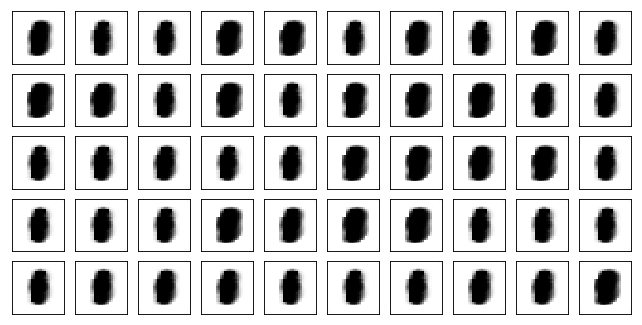

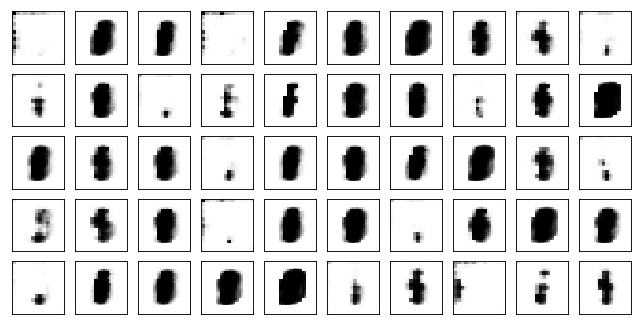

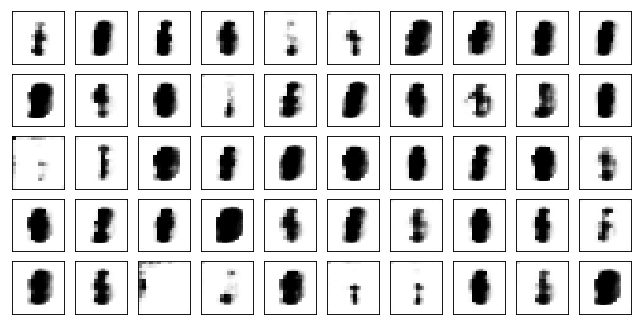

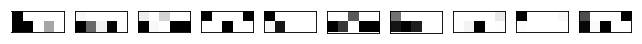

Model RMS Discr+bn+dp:


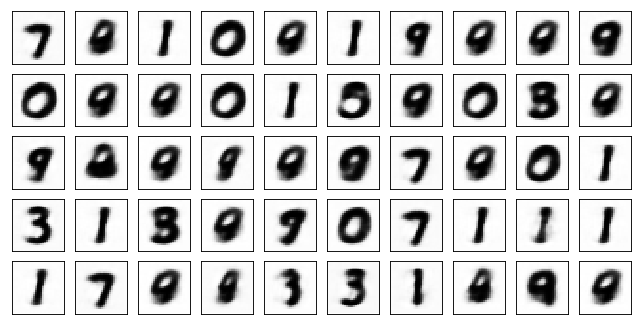

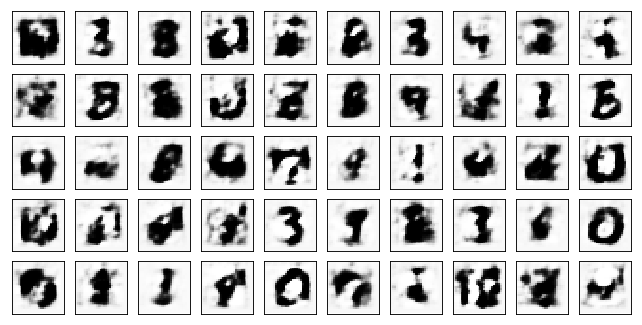

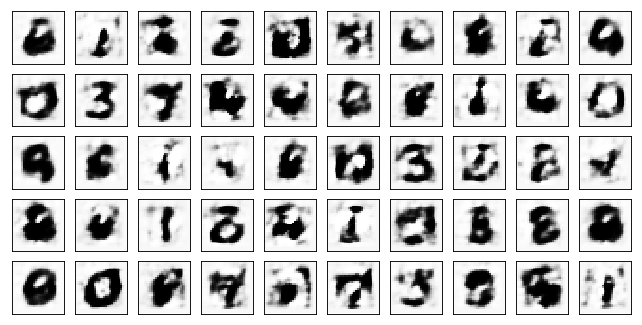

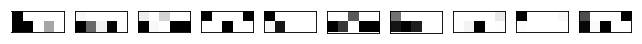

Model Adam Discr+dp:


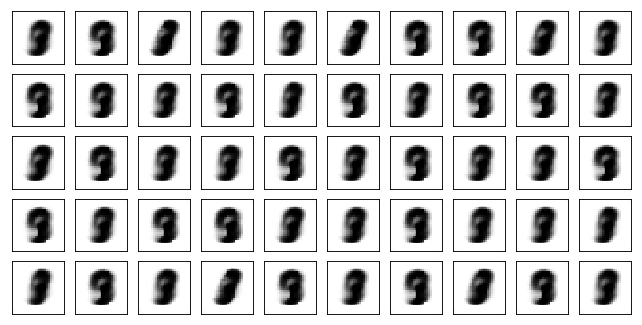

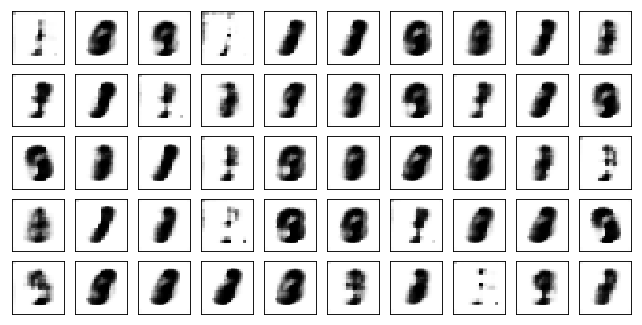

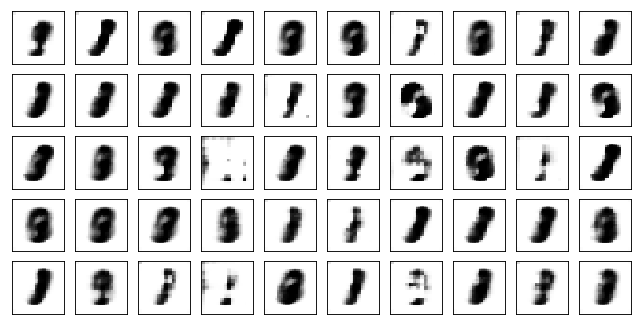

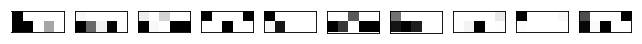

Model Adam Discr+bn+dp:


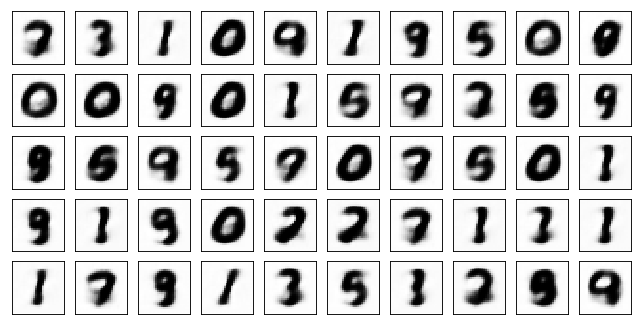

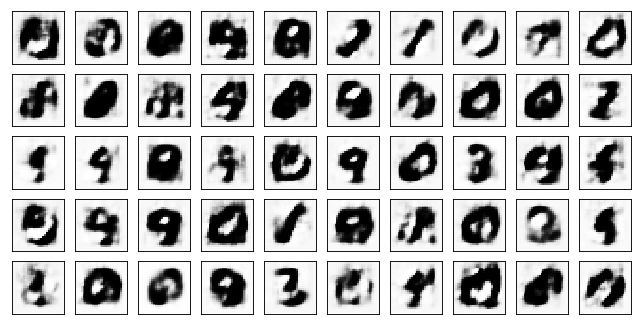

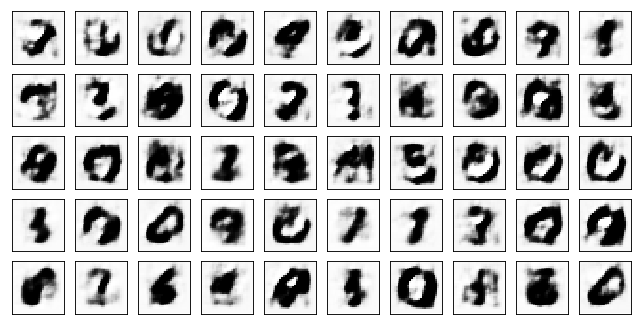

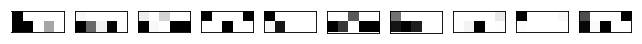

Test losses: 
RMS Discr+dp: 3.99769616 / 13.84807205 / 0.13163596 
RMS Discr+bn+dp: 3.65501738 / 21.88505363 / 0.00570361 
Adam Discr+dp: 3.91429043 / 12.53582764 / 0.14751565 
Adam Discr+bn+dp: 3.61661768 / 19.15186691 / 0.02048798 

Train Epoch: 21 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.3185 D:0.0097 RMS Discr+bn+dp: AE:4.6975 D:0.0007 Adam Discr+dp: AE:3.2536 D:0.0823 Adam Discr+bn+dp: AE:4.7107 D:0.0007
Train Epoch: 21 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.3843 D:0.0144 RMS Discr+bn+dp: AE:4.9843 D:0.0001 Adam Discr+dp: AE:3.3860 D:0.0806 Adam Discr+bn+dp: AE:4.2354 D:0.0011
Train Epoch: 21 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.3128 D:0.0612 RMS Discr+bn+dp: AE:5.1284 D:0.0003 Adam Discr+dp: AE:3.3489 D:0.0072 Adam Discr+bn+dp: AE:4.3313 D:0.0016
Test losses: 
RMS Discr+dp: 3.97128010 / 13.07944393 / 0.13066382 
RMS Discr+bn+dp: 3.60689044 / 22.84589386 / 0.00443611 
Adam Discr+dp: 3.89684677 / 13.85226822 / 0.14605636 
Adam Discr+bn+dp: 3.59649444 / 19.20209885 

Train Epoch: 31 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.1823 D:0.0576 RMS Discr+bn+dp: AE:5.0679 D:0.0001 Adam Discr+dp: AE:3.2674 D:0.0416 Adam Discr+bn+dp: AE:4.5909 D:0.0012
Train Epoch: 31 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.4348 D:0.0164 RMS Discr+bn+dp: AE:5.4239 D:0.0003 Adam Discr+dp: AE:3.1954 D:0.0690 Adam Discr+bn+dp: AE:4.2059 D:0.0010
Test losses: 
RMS Discr+dp: 3.89411330 / 13.75110817 / 0.11058169 
RMS Discr+bn+dp: 3.49198842 / 23.60480118 / 0.00413357 
Adam Discr+dp: 3.91976428 / 13.81337357 / 0.12315802 
Adam Discr+bn+dp: 3.43216085 / 19.66360092 / 0.00877345 

Train Epoch: 32 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.5787 D:0.0445 RMS Discr+bn+dp: AE:5.2598 D:0.0002 Adam Discr+dp: AE:3.2988 D:0.0116 Adam Discr+bn+dp: AE:4.5697 D:0.0037
Train Epoch: 32 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.7107 D:0.0256 RMS Discr+bn+dp: AE:5.4224 D:0.0001 Adam Discr+dp: AE:3.4974 D:0.0785 Adam Discr+bn+dp: AE:4.5222 D:0.0008
Train Epoch: 32 [50000/50000 (100%)]	

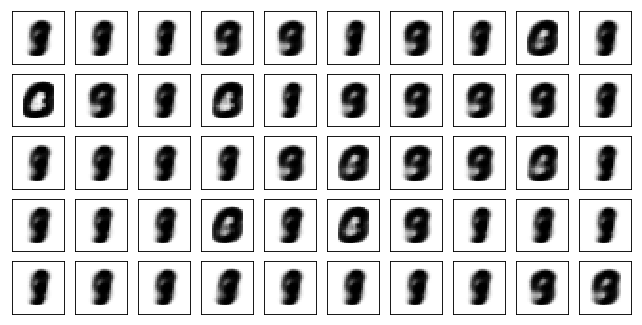

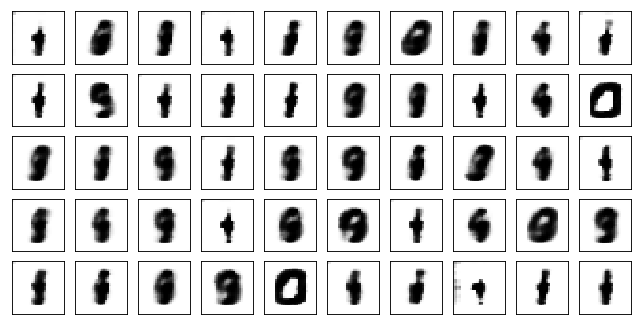

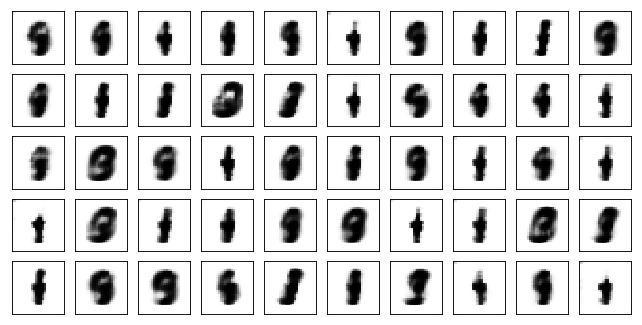

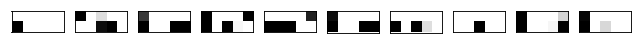

Model RMS Discr+bn+dp:


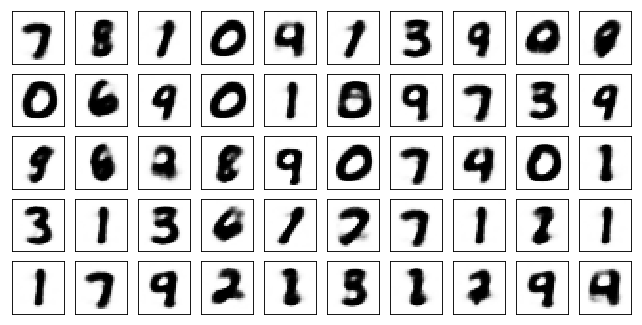

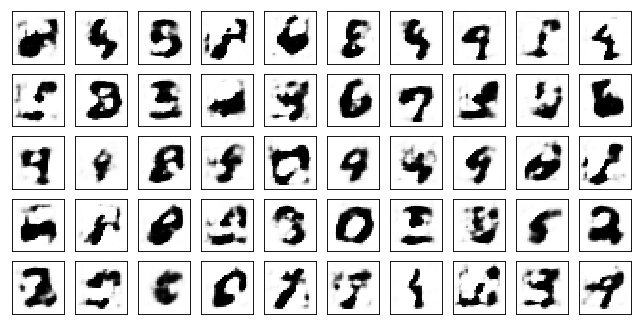

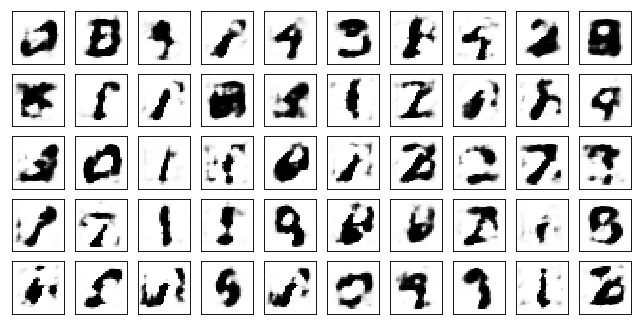

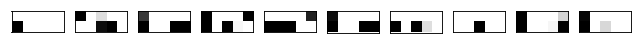

Model Adam Discr+dp:


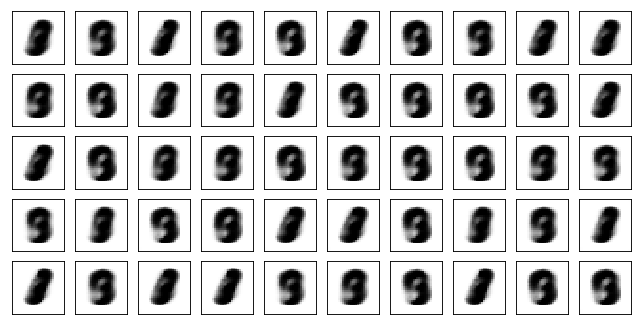

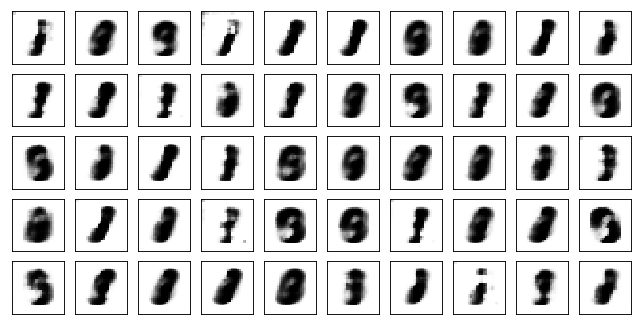

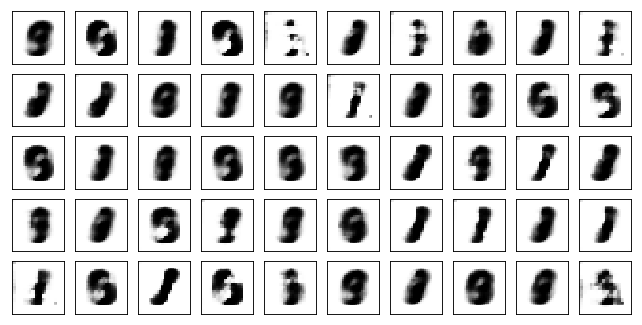

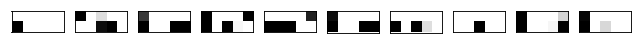

Model Adam Discr+bn+dp:


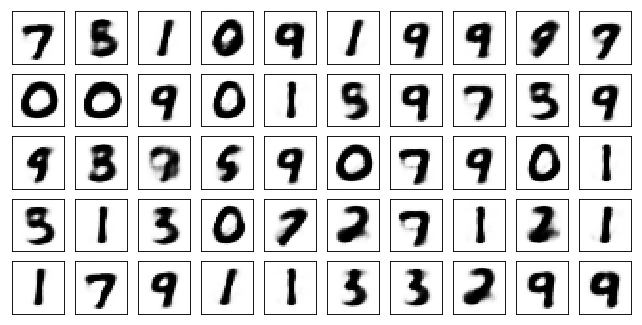

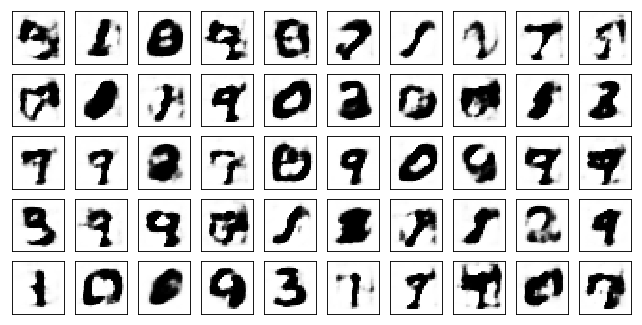

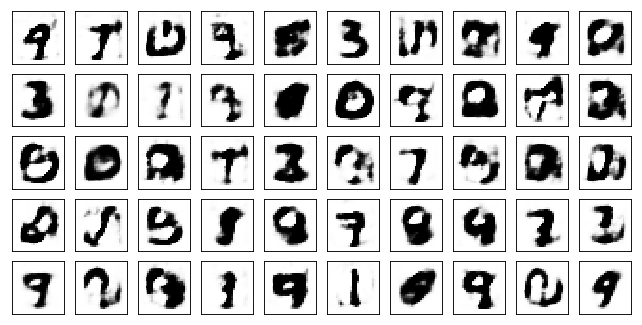

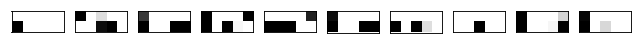

Test losses: 
RMS Discr+dp: 3.84126639 / 15.20077324 / 0.09403406 
RMS Discr+bn+dp: 3.39315963 / 20.93438721 / 0.00679893 
Adam Discr+dp: 3.85553765 / 14.11944771 / 0.11870926 
Adam Discr+bn+dp: 3.38672566 / 21.95262718 / 0.00840525 

Train Epoch: 41 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.5740 D:0.0041 RMS Discr+bn+dp: AE:4.7529 D:0.0007 Adam Discr+dp: AE:3.4587 D:0.0841 Adam Discr+bn+dp: AE:4.9370 D:0.0005
Train Epoch: 41 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.5224 D:0.0057 RMS Discr+bn+dp: AE:5.1827 D:0.0004 Adam Discr+dp: AE:3.4463 D:0.0591 Adam Discr+bn+dp: AE:5.0424 D:0.0010
Train Epoch: 41 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.3906 D:0.0075 RMS Discr+bn+dp: AE:4.7853 D:0.0004 Adam Discr+dp: AE:3.2828 D:0.0120 Adam Discr+bn+dp: AE:5.1371 D:0.0002
Test losses: 
RMS Discr+dp: 3.82500625 / 13.92743301 / 0.09106894 
RMS Discr+bn+dp: 3.40495324 / 22.45952034 / 0.01060926 
Adam Discr+dp: 3.86548185 / 13.38451481 / 0.11430701 
Adam Discr+bn+dp: 3.38811660 / 22.94223785 

Train Epoch: 51 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.4959 D:0.0023 RMS Discr+bn+dp: AE:5.0184 D:0.0006 Adam Discr+dp: AE:3.5294 D:0.0957 Adam Discr+bn+dp: AE:4.4495 D:0.0005
Train Epoch: 51 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.6988 D:0.0282 RMS Discr+bn+dp: AE:5.2371 D:0.0002 Adam Discr+dp: AE:3.4785 D:0.0065 Adam Discr+bn+dp: AE:4.6173 D:0.0009
Test losses: 
RMS Discr+dp: 3.81720996 / 14.44393253 / 0.06868904 
RMS Discr+bn+dp: 3.39552021 / 23.48765564 / 0.00298338 
Adam Discr+dp: 3.88510013 / 13.94845676 / 0.08343445 
Adam Discr+bn+dp: 3.37240338 / 20.04925537 / 0.01212678 

Train Epoch: 52 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.5765 D:0.0583 RMS Discr+bn+dp: AE:5.3073 D:0.0002 Adam Discr+dp: AE:3.5675 D:0.0394 Adam Discr+bn+dp: AE:4.6246 D:0.0006
Train Epoch: 52 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.3958 D:0.0042 RMS Discr+bn+dp: AE:5.2453 D:0.0002 Adam Discr+dp: AE:3.4483 D:0.0038 Adam Discr+bn+dp: AE:4.7976 D:0.0016
Train Epoch: 52 [50000/50000 (100%)]	

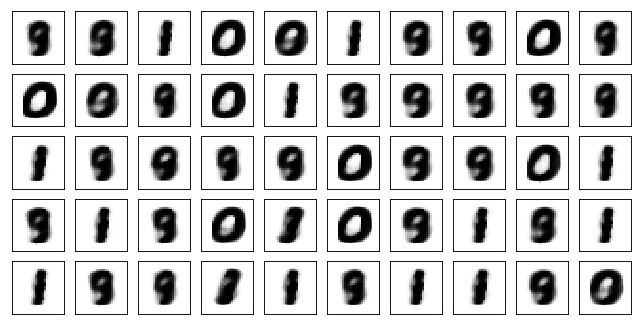

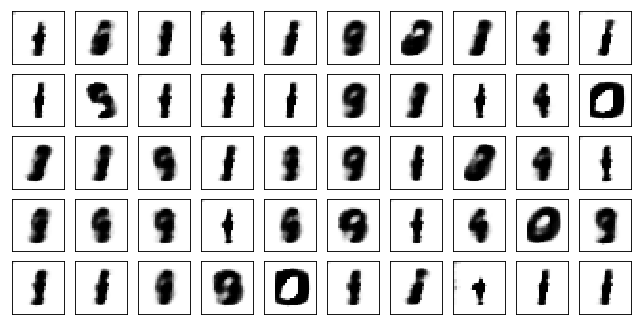

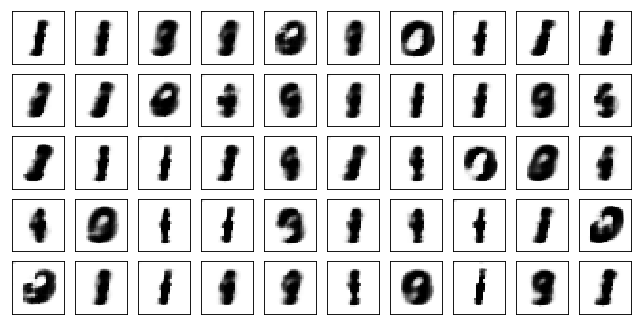

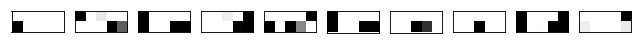

Model RMS Discr+bn+dp:


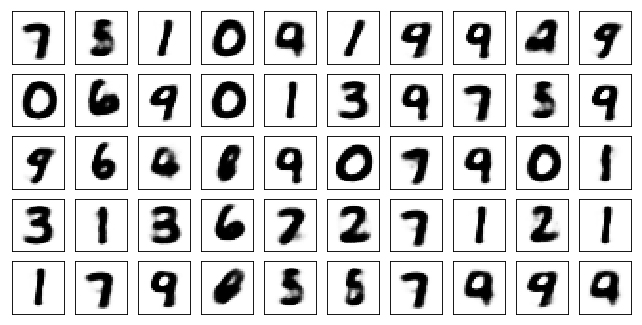

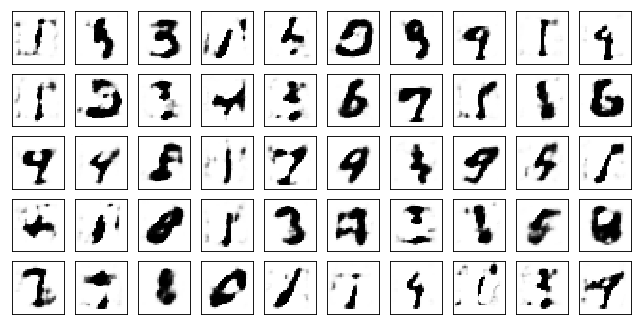

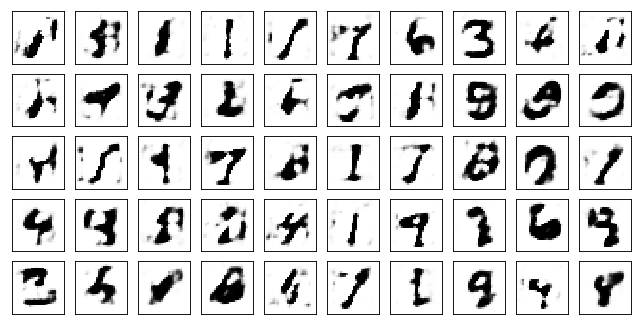

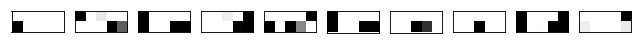

Model Adam Discr+dp:


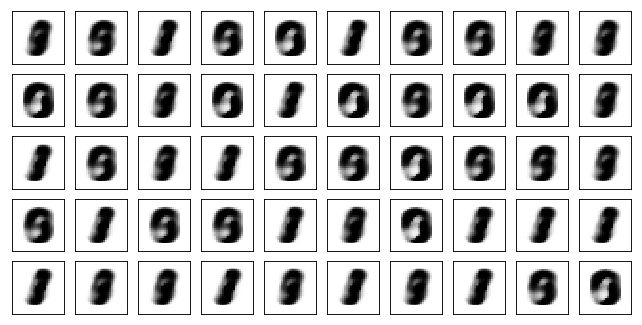

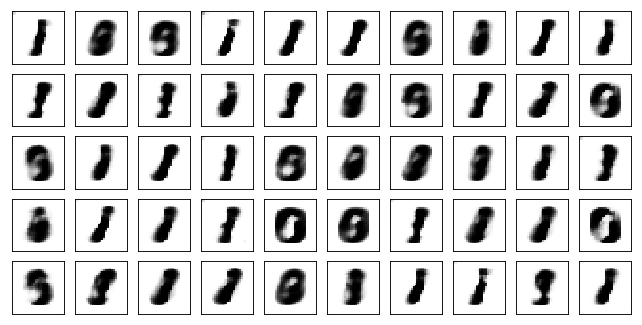

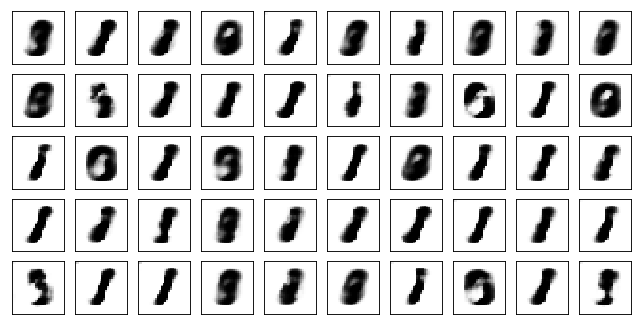

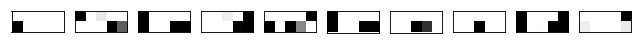

Model Adam Discr+bn+dp:


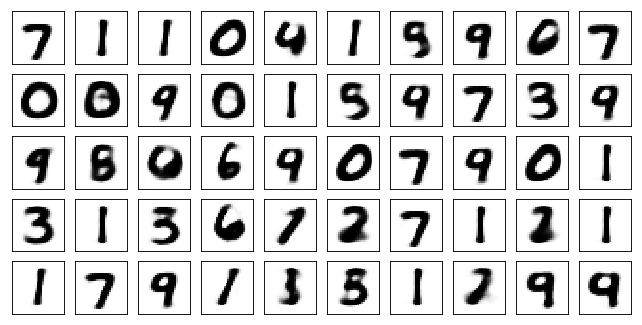

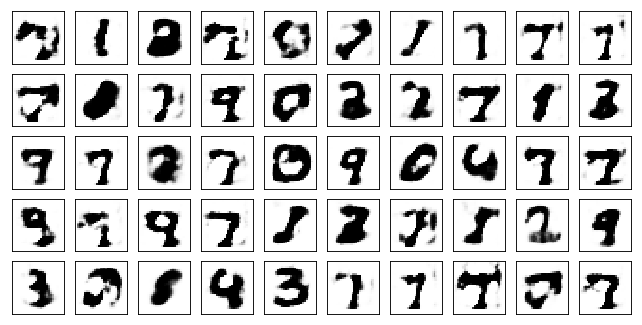

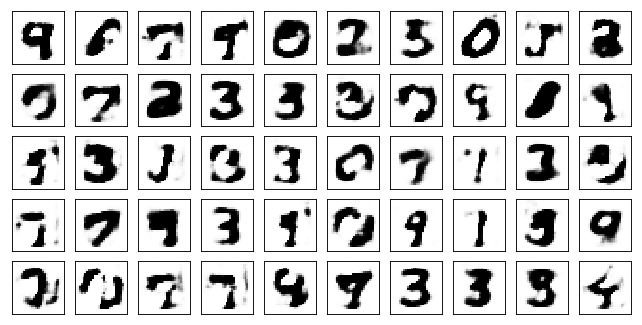

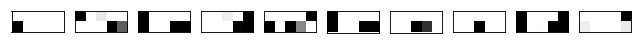

Test losses: 
RMS Discr+dp: 3.74135947 / 15.34345627 / 0.06440567 
RMS Discr+bn+dp: 3.35617518 / 24.23050499 / 0.00176162 
Adam Discr+dp: 3.86503482 / 15.06169415 / 0.07218912 
Adam Discr+bn+dp: 3.32712579 / 21.11789703 / 0.01128279 

Train Epoch: 61 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.5920 D:0.0055 RMS Discr+bn+dp: AE:5.3436 D:0.0003 Adam Discr+dp: AE:3.5991 D:0.0039 Adam Discr+bn+dp: AE:4.4895 D:0.0010
Train Epoch: 61 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.4799 D:0.0061 RMS Discr+bn+dp: AE:5.6547 D:0.0001 Adam Discr+dp: AE:3.5066 D:0.0038 Adam Discr+bn+dp: AE:4.5089 D:0.0102
Train Epoch: 61 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.6906 D:0.0787 RMS Discr+bn+dp: AE:5.5773 D:0.0002 Adam Discr+dp: AE:3.6340 D:0.0046 Adam Discr+bn+dp: AE:4.5483 D:0.0035
Test losses: 
RMS Discr+dp: 3.77490926 / 14.71544743 / 0.05689010 
RMS Discr+bn+dp: 3.36455417 / 25.22718239 / 0.00118981 
Adam Discr+dp: 3.83622193 / 14.65872002 / 0.07309895 
Adam Discr+bn+dp: 3.32836795 / 20.94634247 

Train Epoch: 71 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.8073 D:0.0027 RMS Discr+bn+dp: AE:6.0247 D:0.0000 Adam Discr+dp: AE:3.4921 D:0.0045 Adam Discr+bn+dp: AE:4.6847 D:0.0008
Train Epoch: 71 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.7830 D:0.0021 RMS Discr+bn+dp: AE:5.7411 D:0.0001 Adam Discr+dp: AE:3.7158 D:0.1119 Adam Discr+bn+dp: AE:4.6623 D:0.0006
Test losses: 
RMS Discr+dp: 3.74740481 / 16.30328751 / 0.05110567 
RMS Discr+bn+dp: 3.33484125 / 26.16552353 / 0.00088852 
Adam Discr+dp: 3.82744861 / 15.28916836 / 0.05424846 
Adam Discr+bn+dp: 3.31800294 / 20.44970703 / 0.01346934 

Train Epoch: 72 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.8409 D:0.0018 RMS Discr+bn+dp: AE:5.7289 D:0.0001 Adam Discr+dp: AE:3.7387 D:0.0692 Adam Discr+bn+dp: AE:4.3975 D:0.0009
Train Epoch: 72 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.7167 D:0.0065 RMS Discr+bn+dp: AE:5.5393 D:0.0001 Adam Discr+dp: AE:3.6095 D:0.0108 Adam Discr+bn+dp: AE:4.6782 D:0.0007
Train Epoch: 72 [50000/50000 (100%)]	

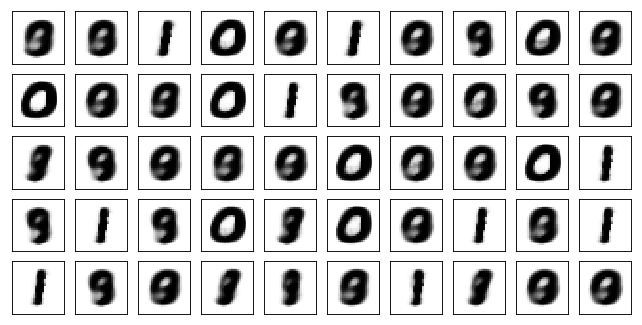

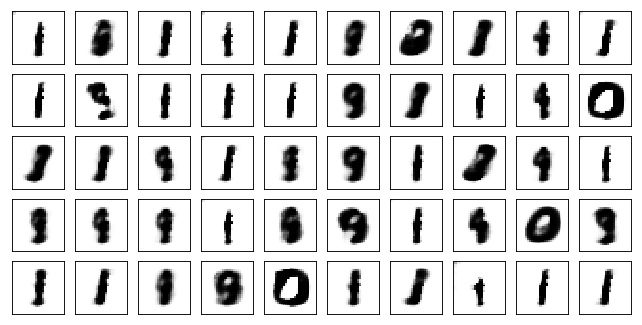

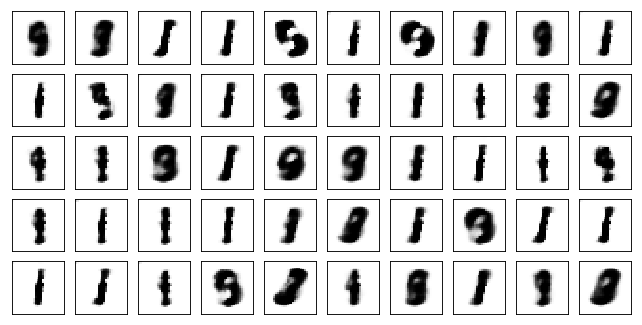

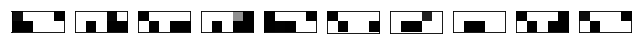

Model RMS Discr+bn+dp:


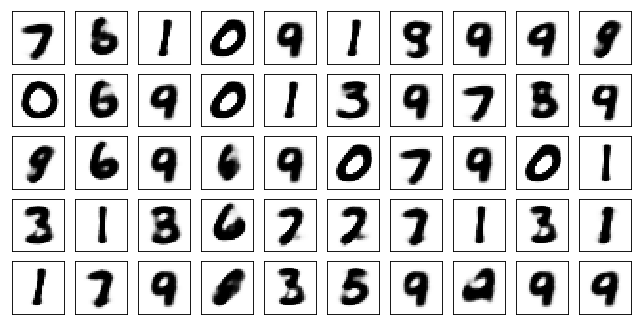

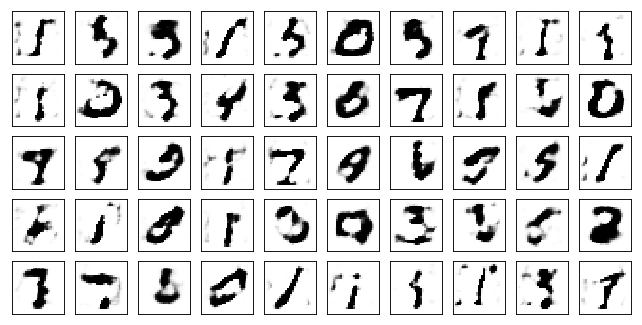

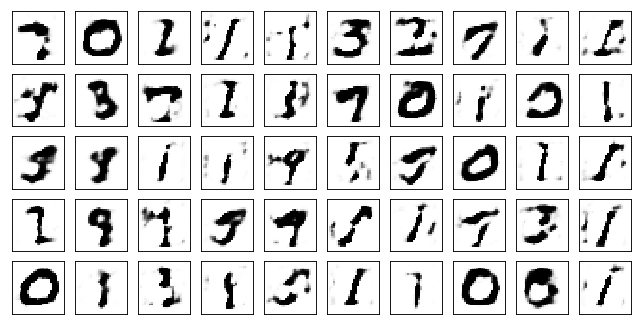

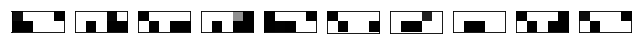

Model Adam Discr+dp:


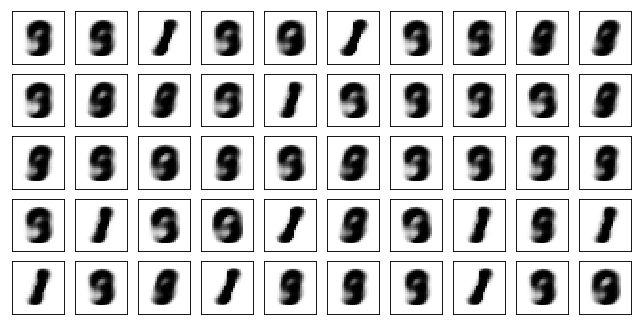

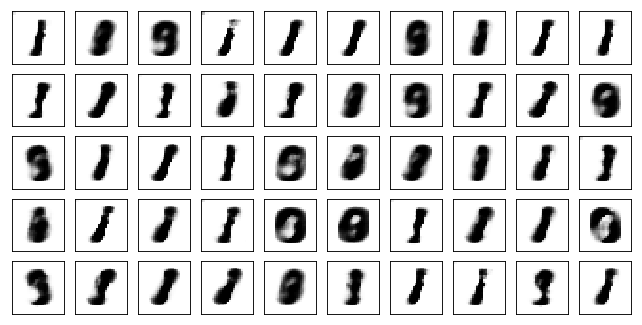

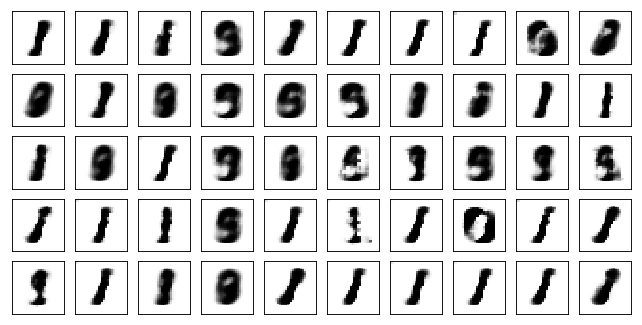

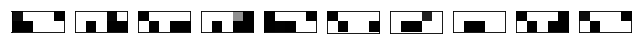

Model Adam Discr+bn+dp:


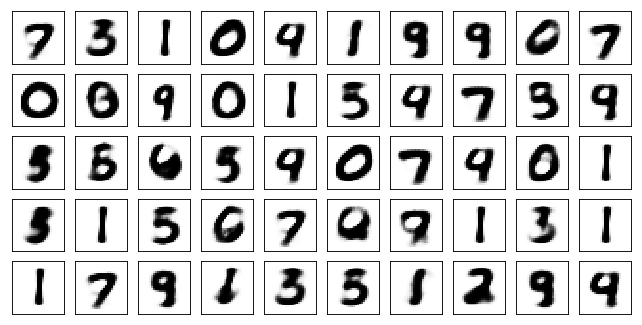

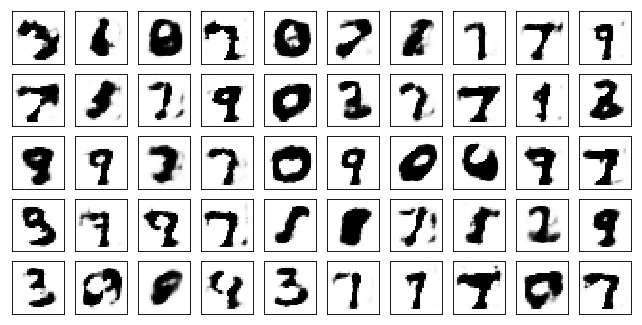

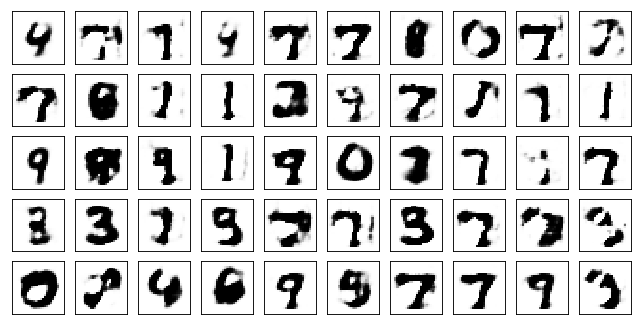

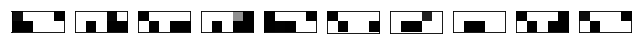

Test losses: 
RMS Discr+dp: 3.69462514 / 16.42452049 / 0.04725664 
RMS Discr+bn+dp: 3.38821697 / 28.19217873 / 0.00134475 
Adam Discr+dp: 3.79187441 / 15.85713387 / 0.04724115 
Adam Discr+bn+dp: 3.36299133 / 19.99707794 / 0.05758552 

Train Epoch: 81 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.6624 D:0.0633 RMS Discr+bn+dp: AE:6.0293 D:0.0000 Adam Discr+dp: AE:3.5548 D:0.0017 Adam Discr+bn+dp: AE:4.6343 D:0.0043
Train Epoch: 81 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.7637 D:0.0016 RMS Discr+bn+dp: AE:6.1421 D:0.0000 Adam Discr+dp: AE:3.6798 D:0.0030 Adam Discr+bn+dp: AE:4.5134 D:0.0043
Train Epoch: 81 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.8351 D:0.0752 RMS Discr+bn+dp: AE:5.7308 D:0.0001 Adam Discr+dp: AE:3.8496 D:0.0043 Adam Discr+bn+dp: AE:4.4902 D:0.0067
Test losses: 
RMS Discr+dp: 3.69681668 / 16.71053886 / 0.04279226 
RMS Discr+bn+dp: 3.32570338 / 26.70812035 / 0.00060638 
Adam Discr+dp: 3.79061365 / 16.96889496 / 0.04941983 
Adam Discr+bn+dp: 3.35243773 / 19.81011391 

Train Epoch: 91 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.9621 D:0.0027 RMS Discr+bn+dp: AE:6.0723 D:0.0000 Adam Discr+dp: AE:4.0224 D:0.0019 Adam Discr+bn+dp: AE:4.2096 D:0.0540
Train Epoch: 91 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.7838 D:0.0037 RMS Discr+bn+dp: AE:6.1720 D:0.0000 Adam Discr+dp: AE:3.9383 D:0.0020 Adam Discr+bn+dp: AE:3.9145 D:0.0150
Test losses: 
RMS Discr+dp: 3.67930555 / 16.34352112 / 0.03915807 
RMS Discr+bn+dp: 3.38510180 / 29.20390129 / 0.00063158 
Adam Discr+dp: 3.80299544 / 17.59180260 / 0.05242836 
Adam Discr+bn+dp: 3.29703760 / 17.83541298 / 0.04834148 

Train Epoch: 92 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.6859 D:0.1002 RMS Discr+bn+dp: AE:6.3188 D:0.0000 Adam Discr+dp: AE:3.9893 D:0.0347 Adam Discr+bn+dp: AE:4.0742 D:0.0085
Train Epoch: 92 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.8411 D:0.0015 RMS Discr+bn+dp: AE:6.5231 D:0.0000 Adam Discr+dp: AE:4.0573 D:0.0076 Adam Discr+bn+dp: AE:4.1261 D:0.0022
Train Epoch: 92 [50000/50000 (100%)]	

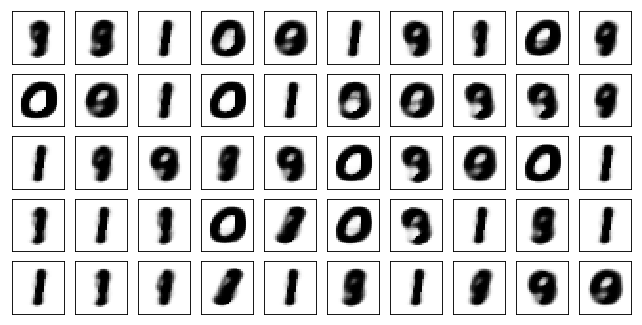

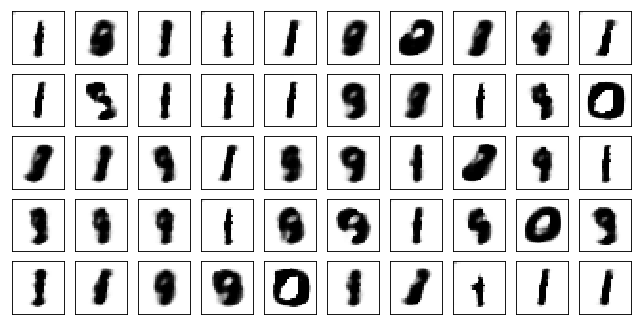

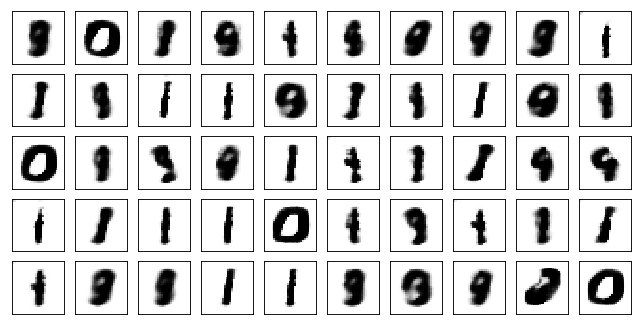

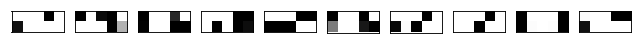

Model RMS Discr+bn+dp:


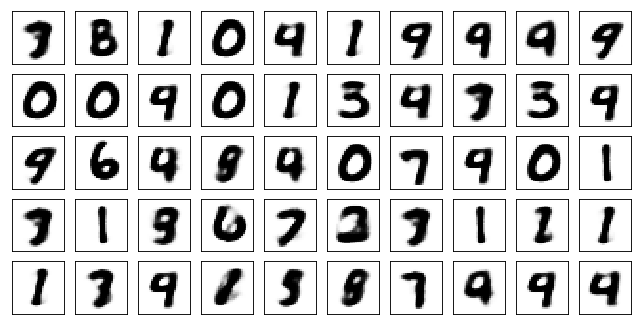

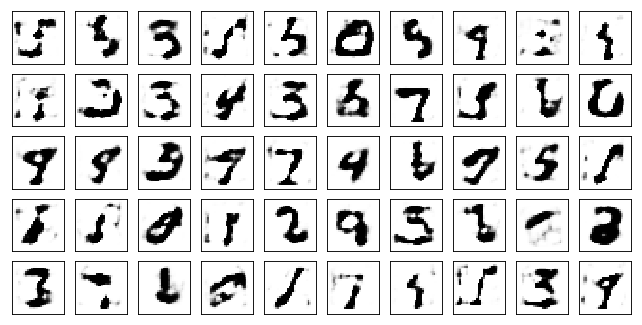

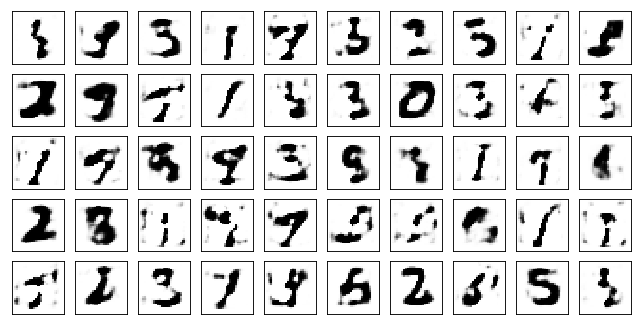

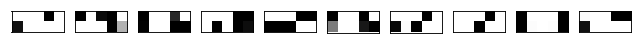

Model Adam Discr+dp:


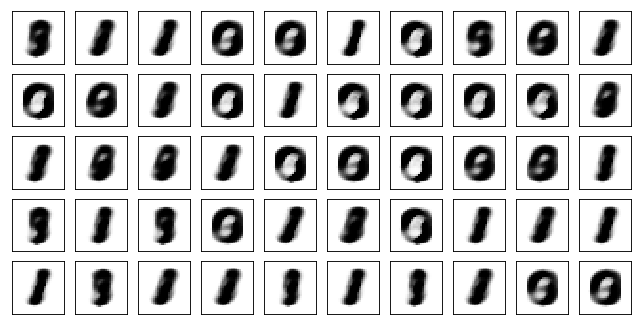

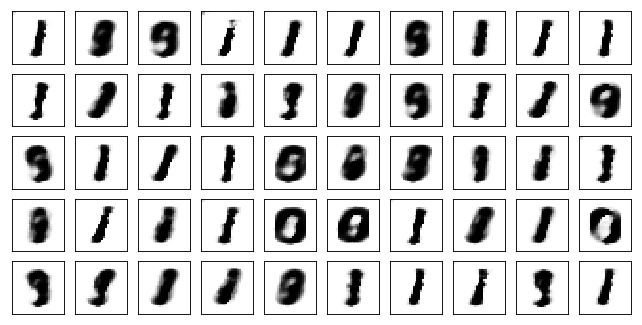

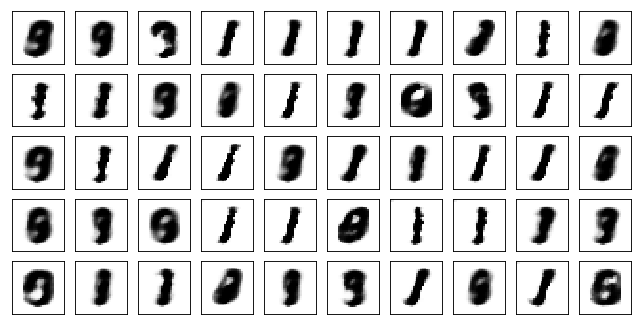

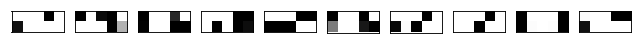

Model Adam Discr+bn+dp:


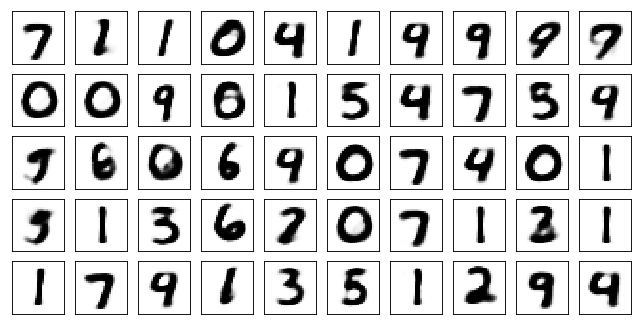

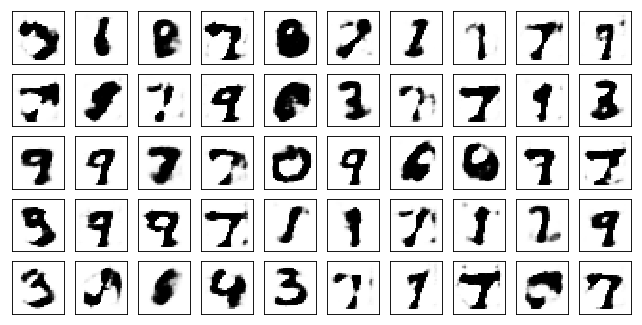

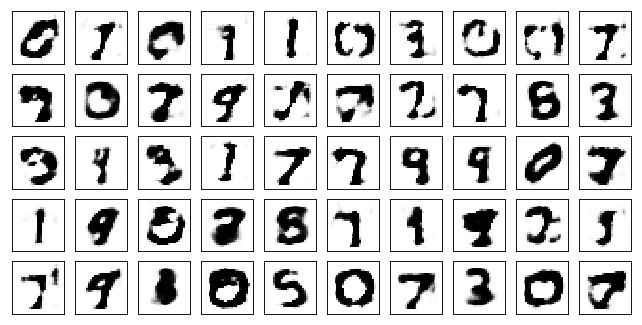

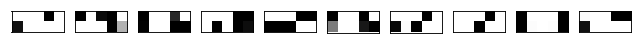

Test losses: 
RMS Discr+dp: 3.69782376 / 17.45826912 / 0.03121271 
RMS Discr+bn+dp: 3.33324885 / 25.71749687 / 0.00060873 
Adam Discr+dp: 3.81328273 / 17.37831306 / 0.04253954 
Adam Discr+bn+dp: 3.28012013 / 17.51553917 / 0.05089891 

Train Epoch: 101 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.8271 D:0.0012 RMS Discr+bn+dp: AE:5.4991 D:0.0002 Adam Discr+dp: AE:4.0238 D:0.0021 Adam Discr+bn+dp: AE:3.6976 D:0.0031
Train Epoch: 101 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.0655 D:0.0011 RMS Discr+bn+dp: AE:5.9560 D:0.0001 Adam Discr+dp: AE:3.9798 D:0.0367 Adam Discr+bn+dp: AE:3.9856 D:0.0017
Train Epoch: 101 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.8759 D:0.0038 RMS Discr+bn+dp: AE:5.5896 D:0.0001 Adam Discr+dp: AE:3.8597 D:0.0033 Adam Discr+bn+dp: AE:3.8754 D:0.0034
Test losses: 
RMS Discr+dp: 3.72449422 / 17.13469887 / 0.03478068 
RMS Discr+bn+dp: 3.36361599 / 25.37584877 / 0.00078168 
Adam Discr+dp: 3.76997113 / 17.57771683 / 0.03535204 
Adam Discr+bn+dp: 3.27643037 / 17.817531

Train Epoch: 111 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.9653 D:0.0020 RMS Discr+bn+dp: AE:5.9493 D:0.0001 Adam Discr+dp: AE:4.2228 D:0.0013 Adam Discr+bn+dp: AE:4.0383 D:0.0375
Train Epoch: 111 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.8688 D:0.0017 RMS Discr+bn+dp: AE:6.2140 D:0.0001 Adam Discr+dp: AE:3.8562 D:0.0018 Adam Discr+bn+dp: AE:3.9770 D:0.0210
Test losses: 
RMS Discr+dp: 3.69240999 / 18.23252678 / 0.03129583 
RMS Discr+bn+dp: 3.43373752 / 28.57804680 / 0.00037841 
Adam Discr+dp: 3.76995659 / 17.78390503 / 0.03155621 
Adam Discr+bn+dp: 3.26302814 / 18.42087555 / 0.05151820 

Train Epoch: 112 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.9385 D:0.0020 RMS Discr+bn+dp: AE:6.0995 D:0.0001 Adam Discr+dp: AE:3.7934 D:0.0027 Adam Discr+bn+dp: AE:3.8798 D:0.0024
Train Epoch: 112 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.7836 D:0.0021 RMS Discr+bn+dp: AE:6.2259 D:0.0000 Adam Discr+dp: AE:3.8217 D:0.0022 Adam Discr+bn+dp: AE:4.0226 D:0.0018
Train Epoch: 112 [50000/50000 (10

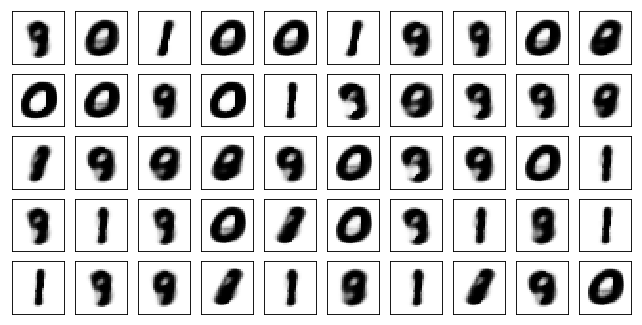

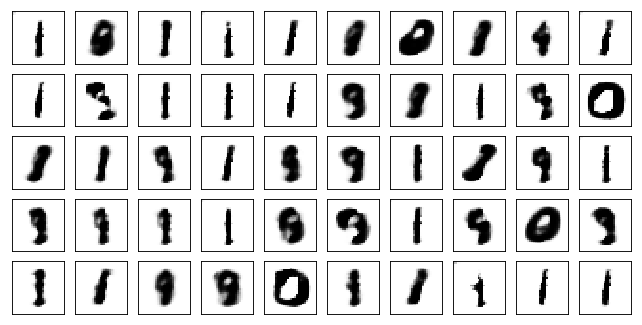

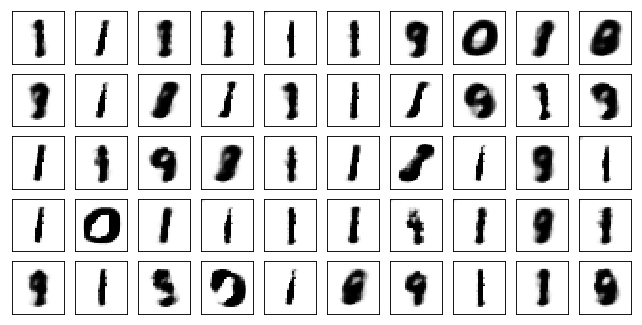

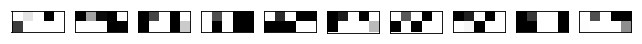

Model RMS Discr+bn+dp:


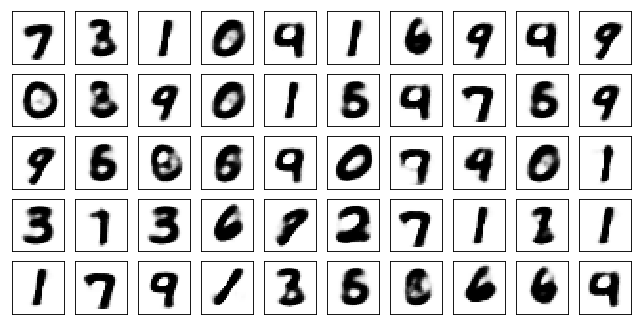

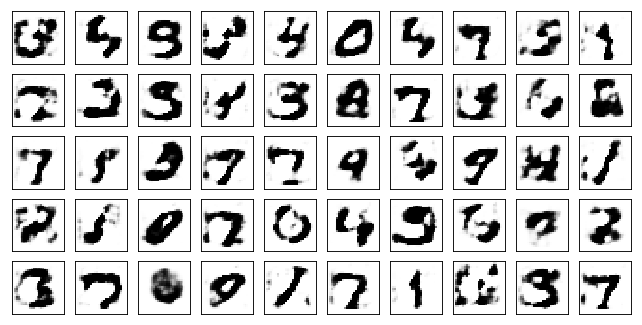

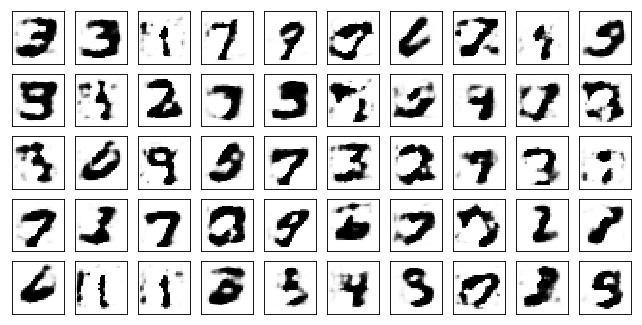

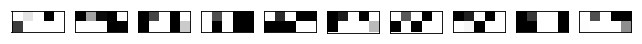

Model Adam Discr+dp:


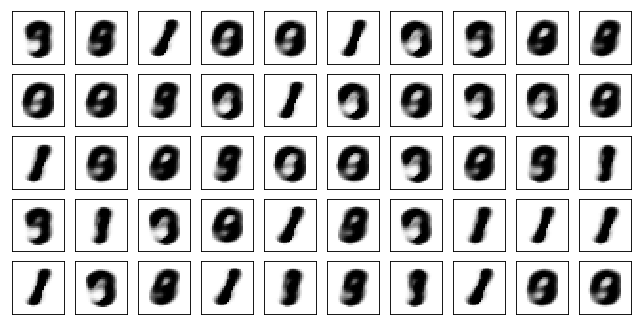

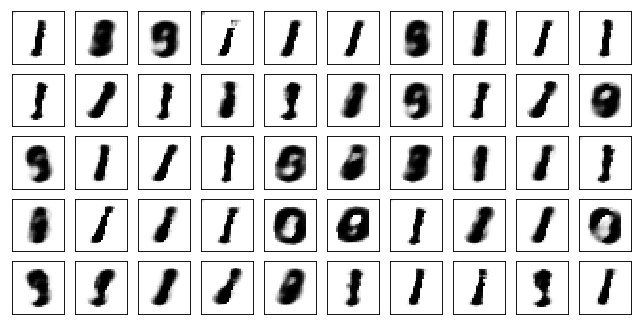

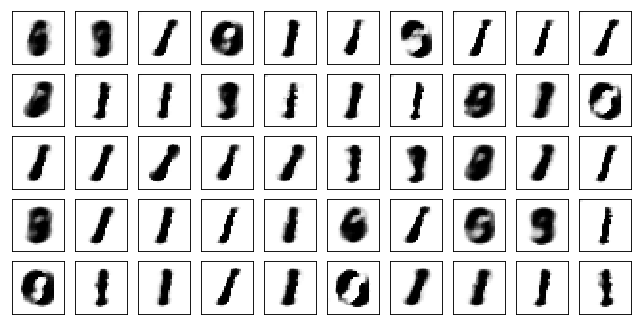

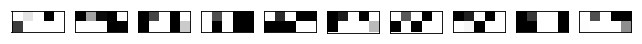

Model Adam Discr+bn+dp:


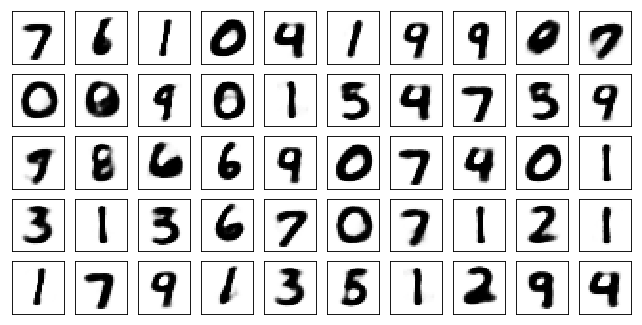

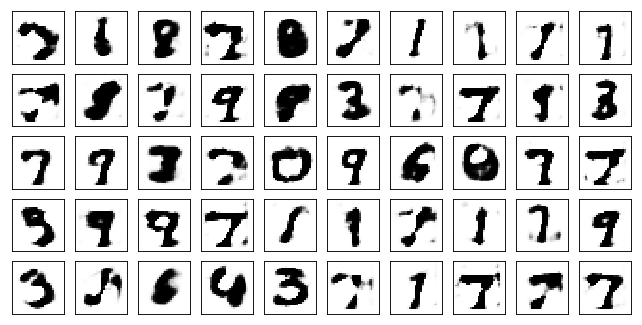

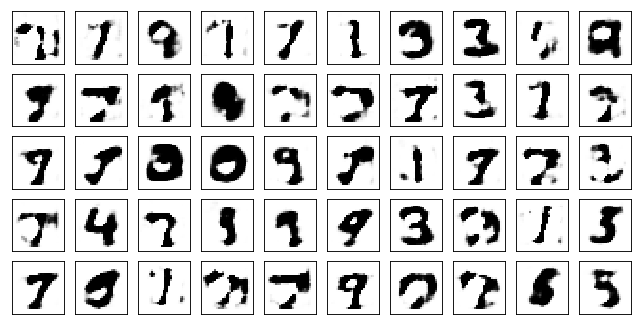

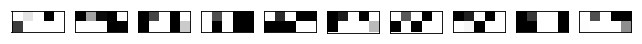

Test losses: 
RMS Discr+dp: 3.69186974 / 18.02499199 / 0.03225808 
RMS Discr+bn+dp: 3.38218474 / 28.29705238 / 0.00104719 
Adam Discr+dp: 3.77298760 / 18.00557137 / 0.02972661 
Adam Discr+bn+dp: 3.24394941 / 16.56873512 / 0.08655231 

Train Epoch: 121 [0/50000 (0%)]	Losses RMS Discr+dp: AE:3.9818 D:0.0012 RMS Discr+bn+dp: AE:6.1788 D:0.0000 Adam Discr+dp: AE:3.8912 D:0.0802 Adam Discr+bn+dp: AE:4.0125 D:0.0041
Train Epoch: 121 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.9973 D:0.0012 RMS Discr+bn+dp: AE:5.9604 D:0.0001 Adam Discr+dp: AE:4.0297 D:0.0028 Adam Discr+bn+dp: AE:3.5767 D:0.0274
Train Epoch: 121 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.9968 D:0.0018 RMS Discr+bn+dp: AE:5.8769 D:0.0000 Adam Discr+dp: AE:4.2203 D:0.0020 Adam Discr+bn+dp: AE:3.8354 D:0.0034
Test losses: 
RMS Discr+dp: 3.66065121 / 18.19723129 / 0.03231987 
RMS Discr+bn+dp: 3.40202379 / 27.97239494 / 0.00013676 
Adam Discr+dp: 3.77274752 / 18.41476631 / 0.03075199 
Adam Discr+bn+dp: 3.24518418 / 17.266416

Train Epoch: 131 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.1756 D:0.0010 RMS Discr+bn+dp: AE:5.5697 D:0.0002 Adam Discr+dp: AE:4.2494 D:0.0264 Adam Discr+bn+dp: AE:3.6444 D:0.0035
Train Epoch: 131 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.2288 D:0.0012 RMS Discr+bn+dp: AE:5.9422 D:0.0001 Adam Discr+dp: AE:3.9634 D:0.0012 Adam Discr+bn+dp: AE:3.6293 D:0.0709
Test losses: 
RMS Discr+dp: 3.69012713 / 18.91391373 / 0.03140248 
RMS Discr+bn+dp: 3.36258793 / 28.09303474 / 0.00016996 
Adam Discr+dp: 3.71184015 / 17.43568420 / 0.02995881 
Adam Discr+bn+dp: 3.20306611 / 15.69403076 / 0.06795238 

Train Epoch: 132 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.0193 D:0.0010 RMS Discr+bn+dp: AE:5.9042 D:0.0000 Adam Discr+dp: AE:3.8368 D:0.0018 Adam Discr+bn+dp: AE:3.7011 D:0.0850
Train Epoch: 132 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.2187 D:0.0027 RMS Discr+bn+dp: AE:5.9091 D:0.0000 Adam Discr+dp: AE:4.0034 D:0.0155 Adam Discr+bn+dp: AE:3.5560 D:0.0059
Train Epoch: 132 [50000/50000 (10

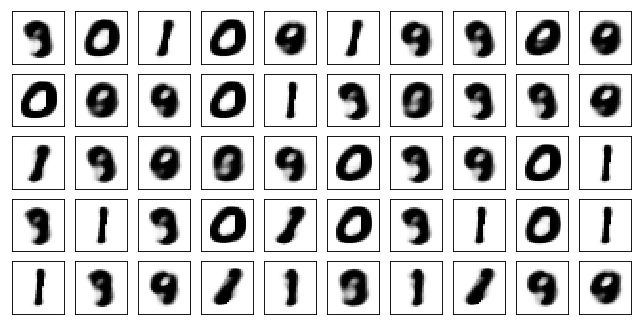

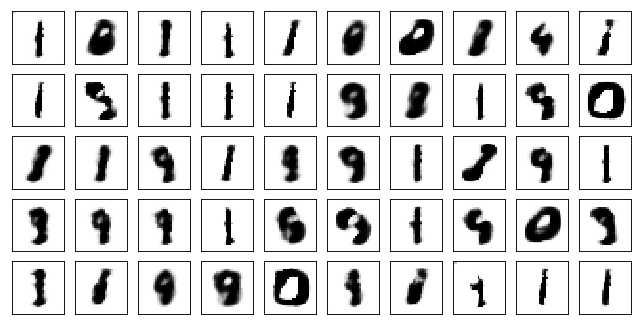

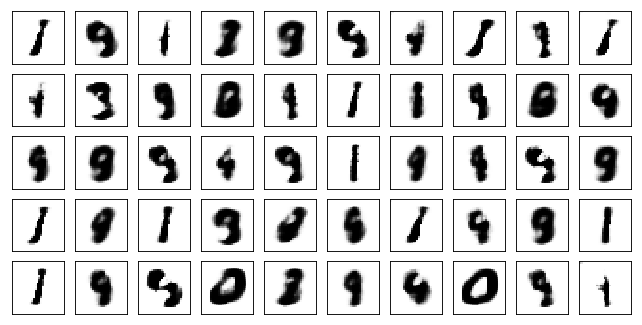

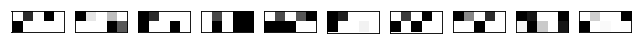

Model RMS Discr+bn+dp:


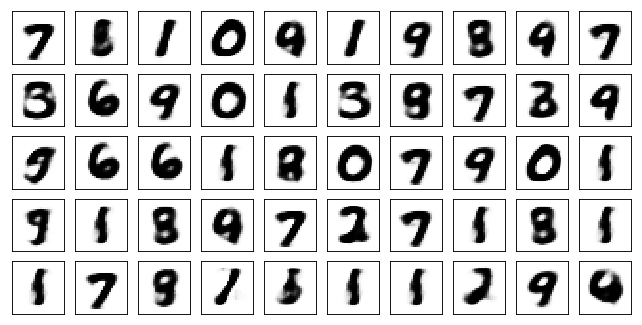

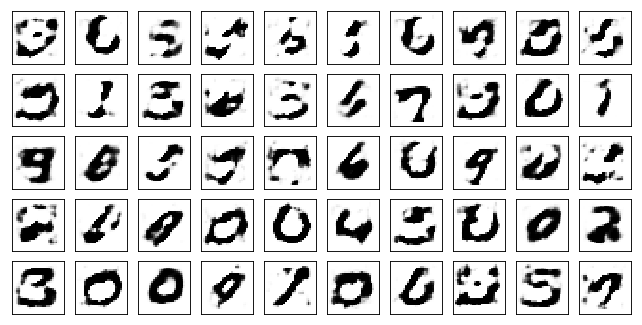

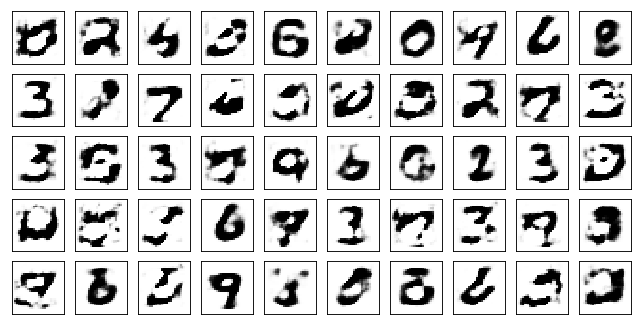

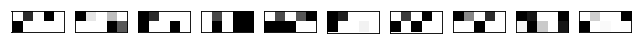

Model Adam Discr+dp:


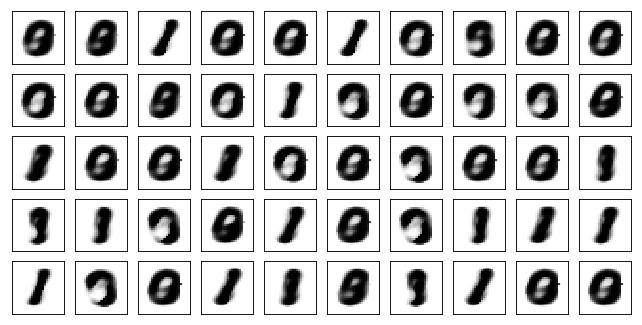

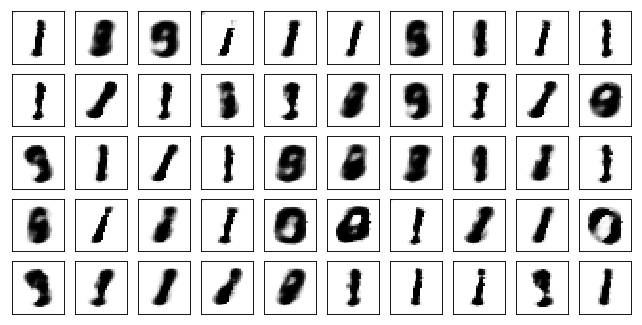

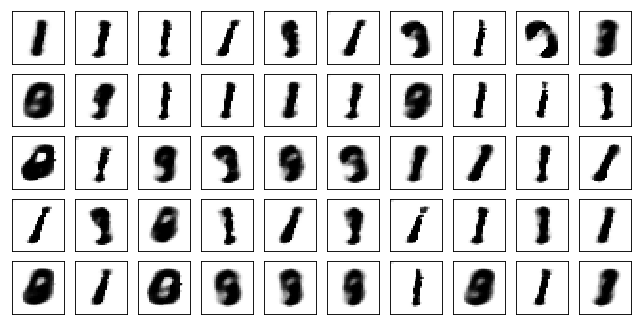

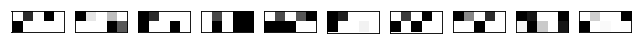

Model Adam Discr+bn+dp:


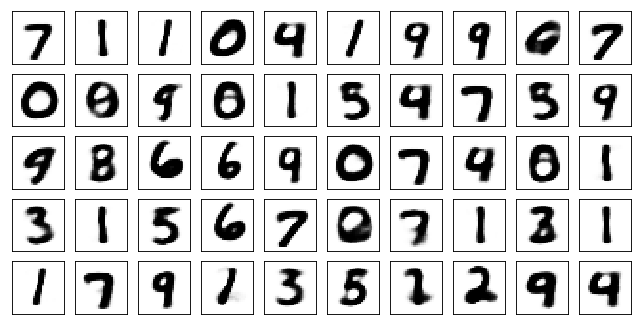

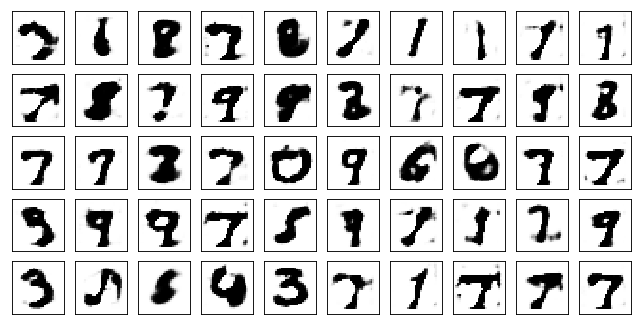

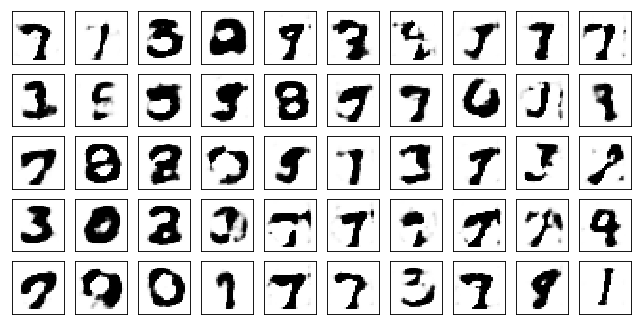

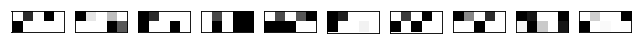

Test losses: 
RMS Discr+dp: 3.62928510 / 19.06679153 / 0.02822196 
RMS Discr+bn+dp: 3.38883758 / 28.22365189 / 0.00063952 
Adam Discr+dp: 3.76229095 / 19.53529549 / 0.02981108 
Adam Discr+bn+dp: 3.18954587 / 16.28108978 / 0.06834577 

Train Epoch: 141 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.0458 D:0.0047 RMS Discr+bn+dp: AE:6.1527 D:0.0001 Adam Discr+dp: AE:4.1919 D:0.0012 Adam Discr+bn+dp: AE:3.7618 D:0.0105
Train Epoch: 141 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:3.9598 D:0.0018 RMS Discr+bn+dp: AE:5.9869 D:0.0000 Adam Discr+dp: AE:4.0132 D:0.0154 Adam Discr+bn+dp: AE:3.9720 D:0.0029
Train Epoch: 141 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.0055 D:0.0016 RMS Discr+bn+dp: AE:5.9974 D:0.0001 Adam Discr+dp: AE:4.0956 D:0.0371 Adam Discr+bn+dp: AE:3.8236 D:0.0052
Test losses: 
RMS Discr+dp: 3.64056349 / 19.36283684 / 0.02951930 
RMS Discr+bn+dp: 3.52615166 / 28.61882782 / 0.00008740 
Adam Discr+dp: 3.76426101 / 19.23330498 / 0.02518460 
Adam Discr+bn+dp: 3.18982840 / 16.121225

Train Epoch: 151 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.1433 D:0.0021 RMS Discr+bn+dp: AE:5.9102 D:0.0000 Adam Discr+dp: AE:4.0651 D:0.0009 Adam Discr+bn+dp: AE:3.8261 D:0.0129
Train Epoch: 151 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.2551 D:0.0014 RMS Discr+bn+dp: AE:6.1136 D:0.0000 Adam Discr+dp: AE:4.1734 D:0.0016 Adam Discr+bn+dp: AE:3.6988 D:0.0027
Test losses: 
RMS Discr+dp: 3.65322256 / 19.92818642 / 0.02955709 
RMS Discr+bn+dp: 3.51257896 / 29.31584358 / 0.00115268 
Adam Discr+dp: 3.69234920 / 19.54731941 / 0.02692178 
Adam Discr+bn+dp: 3.18199492 / 16.17883492 / 0.05463560 

Train Epoch: 152 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.2920 D:0.0010 RMS Discr+bn+dp: AE:6.0397 D:0.0000 Adam Discr+dp: AE:4.1597 D:0.0681 Adam Discr+bn+dp: AE:3.8656 D:0.0025
Train Epoch: 152 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.1142 D:0.0017 RMS Discr+bn+dp: AE:6.0900 D:0.0001 Adam Discr+dp: AE:3.9675 D:0.0012 Adam Discr+bn+dp: AE:3.8148 D:0.0022
Train Epoch: 152 [50000/50000 (10

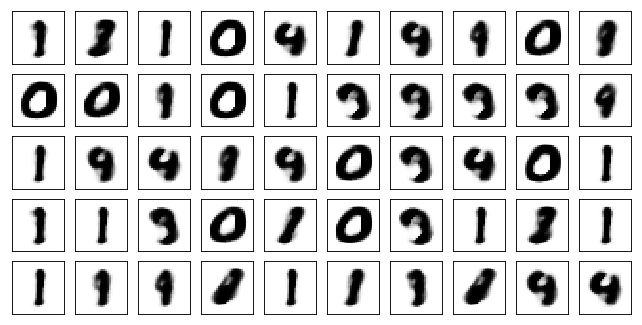

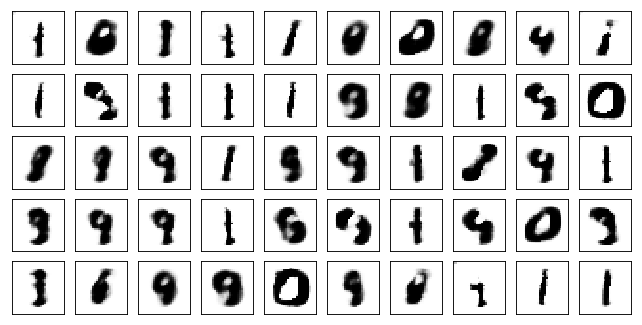

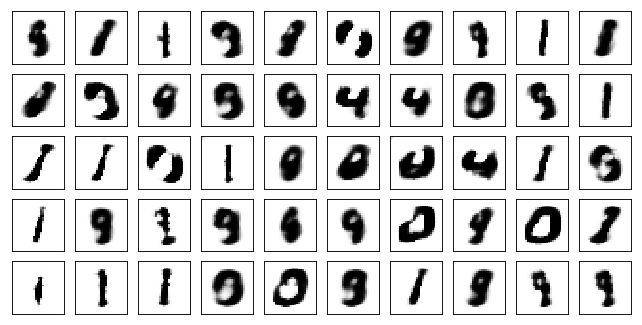

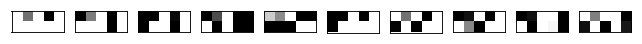

Model RMS Discr+bn+dp:


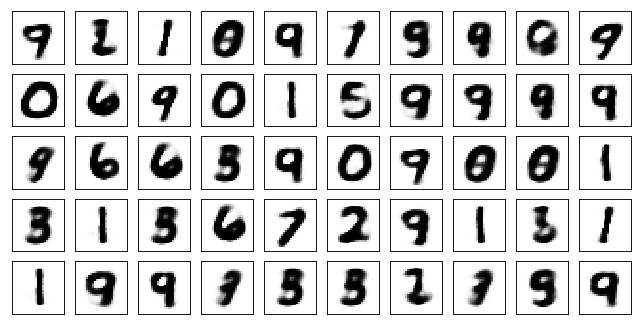

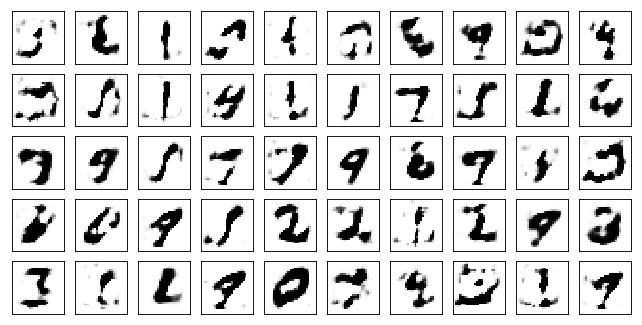

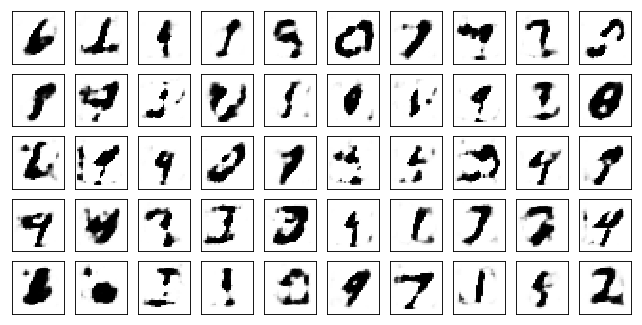

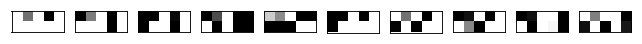

Model Adam Discr+dp:


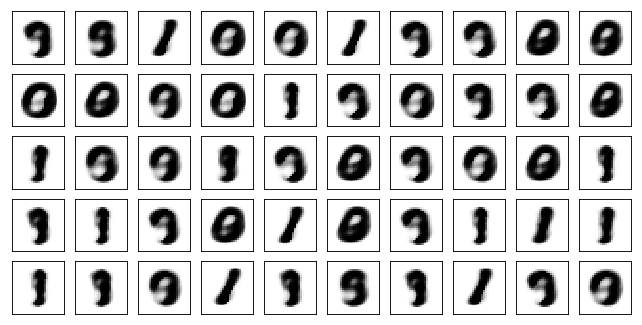

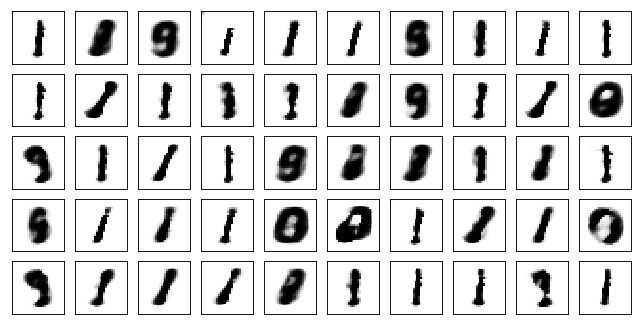

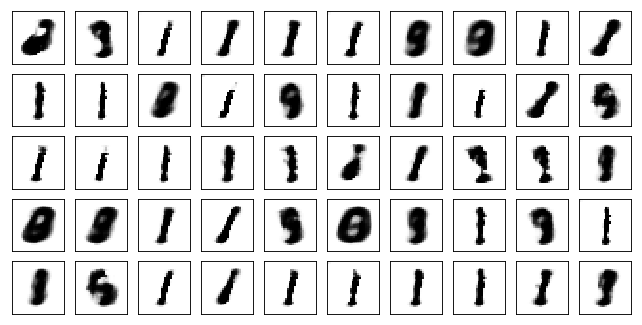

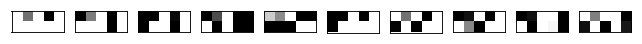

Model Adam Discr+bn+dp:


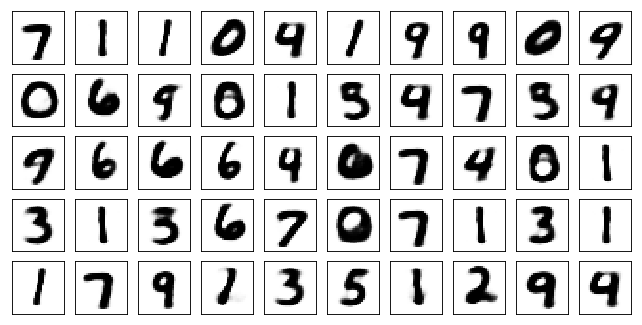

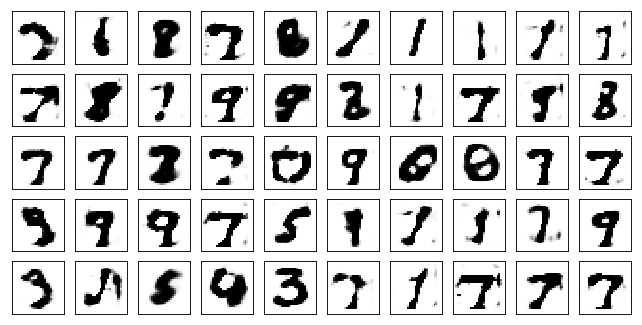

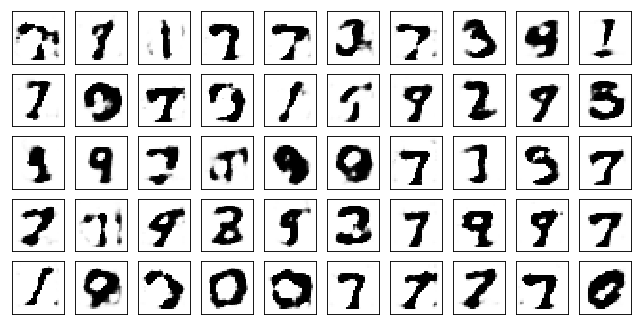

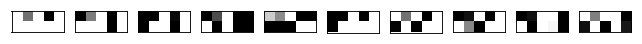

Test losses: 
RMS Discr+dp: 3.66171932 / 19.65923119 / 0.01936276 
RMS Discr+bn+dp: 3.41534448 / 29.53391266 / 0.00059505 
Adam Discr+dp: 3.70004725 / 19.63839340 / 0.01852967 
Adam Discr+bn+dp: 3.18943071 / 17.91478539 / 0.04444826 

Train Epoch: 161 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.3636 D:0.0696 RMS Discr+bn+dp: AE:6.3044 D:0.0000 Adam Discr+dp: AE:4.3746 D:0.0017 Adam Discr+bn+dp: AE:4.0831 D:0.0054
Train Epoch: 161 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.1365 D:0.0024 RMS Discr+bn+dp: AE:6.3581 D:0.0000 Adam Discr+dp: AE:4.3206 D:0.0360 Adam Discr+bn+dp: AE:4.1338 D:0.0021
Train Epoch: 161 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.3473 D:0.0009 RMS Discr+bn+dp: AE:6.0977 D:0.0000 Adam Discr+dp: AE:4.2478 D:0.0011 Adam Discr+bn+dp: AE:3.7056 D:0.0751
Test losses: 
RMS Discr+dp: 3.61110401 / 19.78853416 / 0.02294290 
RMS Discr+bn+dp: 3.42357779 / 29.63488388 / 0.00017382 
Adam Discr+dp: 3.68555260 / 19.67959595 / 0.02873228 
Adam Discr+bn+dp: 3.17178082 / 16.378356

Train Epoch: 171 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.2019 D:0.0745 RMS Discr+bn+dp: AE:5.9416 D:0.0000 Adam Discr+dp: AE:4.2304 D:0.0012 Adam Discr+bn+dp: AE:3.7129 D:0.0023
Train Epoch: 171 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:3.9232 D:0.0019 RMS Discr+bn+dp: AE:5.9881 D:0.0001 Adam Discr+dp: AE:4.0732 D:0.0010 Adam Discr+bn+dp: AE:3.7498 D:0.0021
Test losses: 
RMS Discr+dp: 3.65690398 / 19.01364899 / 0.02140520 
RMS Discr+bn+dp: 3.37985444 / 27.92090988 / 0.00008918 
Adam Discr+dp: 3.69506359 / 20.34496689 / 0.01980874 
Adam Discr+bn+dp: 3.18462396 / 16.30053902 / 0.04025575 

Train Epoch: 172 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.1410 D:0.0023 RMS Discr+bn+dp: AE:5.8441 D:0.0001 Adam Discr+dp: AE:4.3312 D:0.0152 Adam Discr+bn+dp: AE:3.8476 D:0.0021
Train Epoch: 172 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.2823 D:0.0010 RMS Discr+bn+dp: AE:6.2808 D:0.0000 Adam Discr+dp: AE:4.4415 D:0.0006 Adam Discr+bn+dp: AE:4.1763 D:0.0014
Train Epoch: 172 [50000/50000 (10

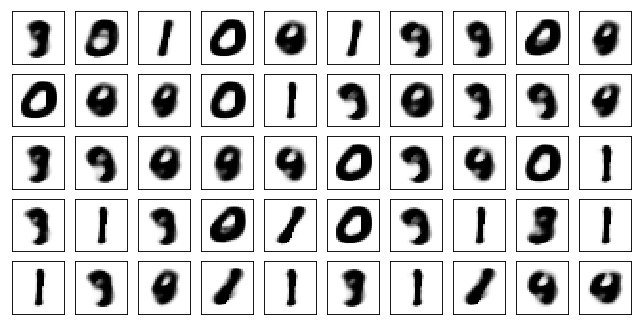

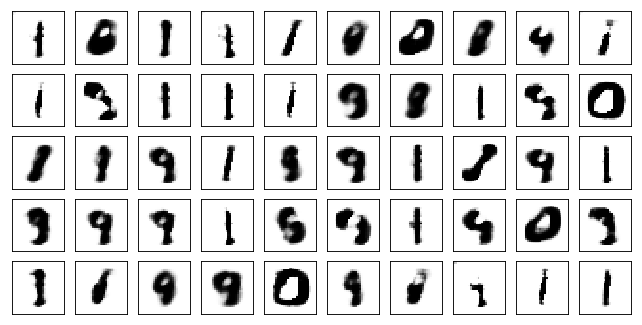

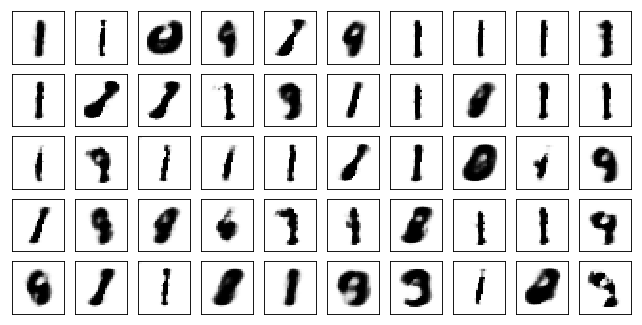

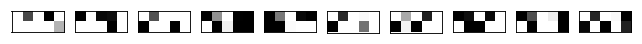

Model RMS Discr+bn+dp:


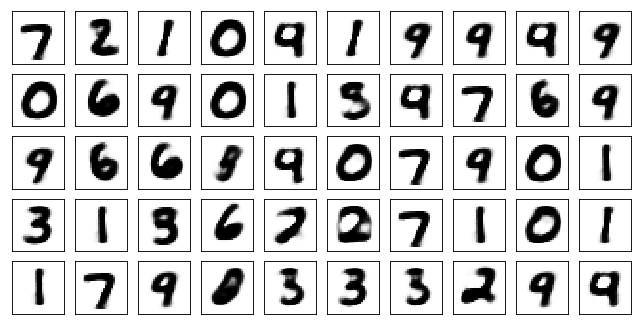

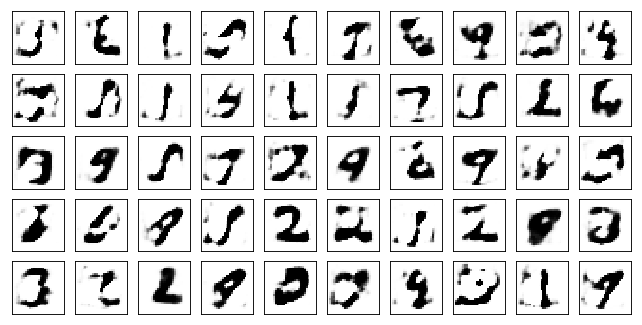

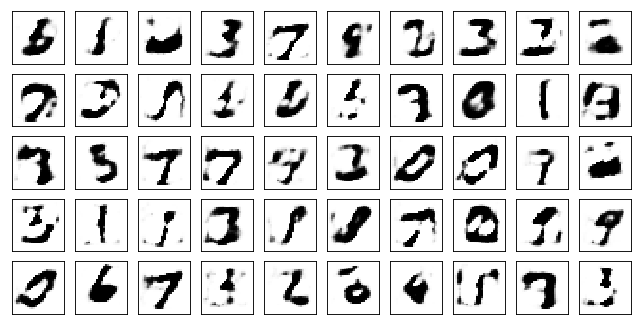

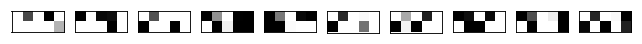

Model Adam Discr+dp:


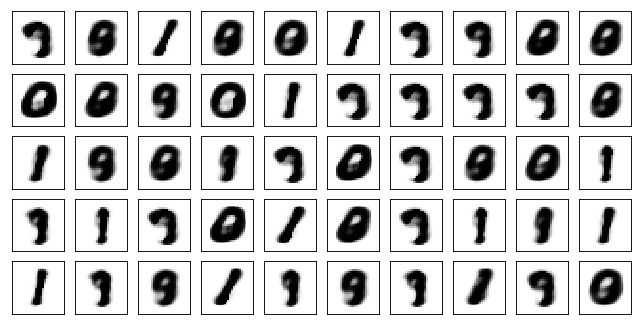

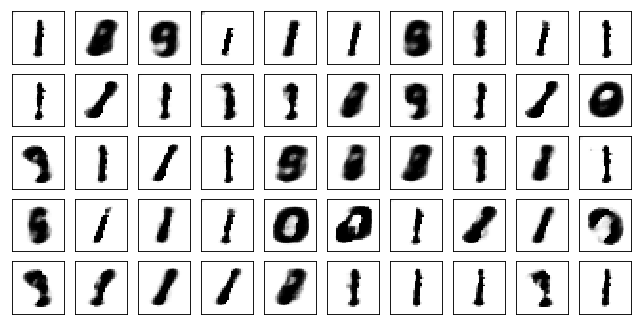

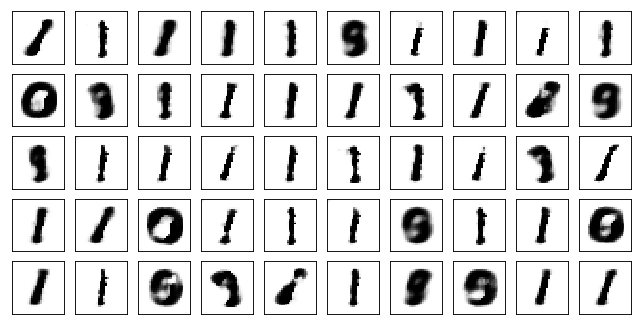

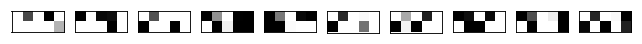

Model Adam Discr+bn+dp:


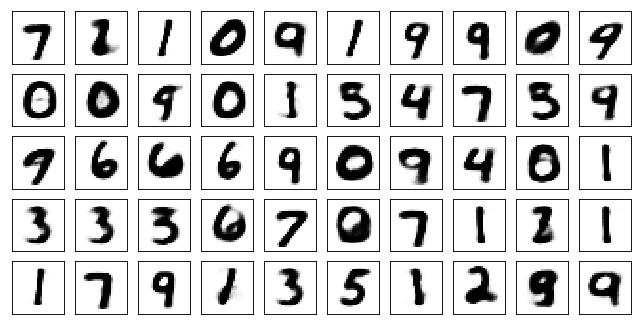

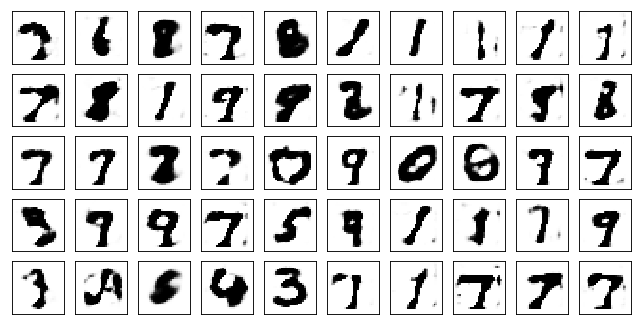

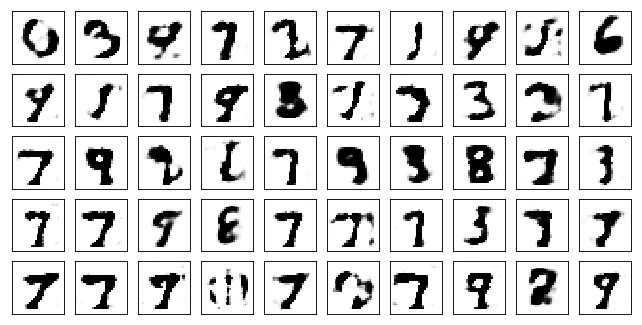

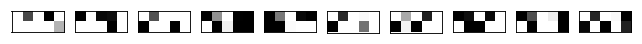

Test losses: 
RMS Discr+dp: 3.60368156 / 21.17637634 / 0.02279711 
RMS Discr+bn+dp: 3.37191892 / 30.97151566 / 0.00003408 
Adam Discr+dp: 3.64941072 / 20.58815575 / 0.01999643 
Adam Discr+bn+dp: 3.17997098 / 17.05295944 / 0.03395252 

Train Epoch: 181 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.2071 D:0.0008 RMS Discr+bn+dp: AE:6.1341 D:0.0000 Adam Discr+dp: AE:4.4313 D:0.0008 Adam Discr+bn+dp: AE:4.0115 D:0.0024
Train Epoch: 181 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.2714 D:0.0014 RMS Discr+bn+dp: AE:6.4962 D:0.0000 Adam Discr+dp: AE:4.6488 D:0.0025 Adam Discr+bn+dp: AE:3.6937 D:0.0017
Train Epoch: 181 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.4310 D:0.0012 RMS Discr+bn+dp: AE:6.1815 D:0.0000 Adam Discr+dp: AE:4.4391 D:0.0052 Adam Discr+bn+dp: AE:3.8100 D:0.0024
Test losses: 
RMS Discr+dp: 3.61606741 / 20.82072067 / 0.02482377 
RMS Discr+bn+dp: 3.35290432 / 29.89394379 / 0.00029528 
Adam Discr+dp: 3.64075303 / 20.86123466 / 0.01805881 
Adam Discr+bn+dp: 3.16964746 / 16.286167

Train Epoch: 191 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.3982 D:0.0036 RMS Discr+bn+dp: AE:6.8422 D:0.0000 Adam Discr+dp: AE:4.3206 D:0.0011 Adam Discr+bn+dp: AE:3.9429 D:0.0032
Train Epoch: 191 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.4693 D:0.0010 RMS Discr+bn+dp: AE:6.7066 D:0.0000 Adam Discr+dp: AE:4.3090 D:0.0012 Adam Discr+bn+dp: AE:4.1083 D:0.0012
Test losses: 
RMS Discr+dp: 3.63513136 / 21.21405220 / 0.01711273 
RMS Discr+bn+dp: 3.36433864 / 32.72146988 / 0.00042227 
Adam Discr+dp: 3.67370105 / 20.67216492 / 0.01974207 
Adam Discr+bn+dp: 3.19451475 / 17.55512428 / 0.03009110 

Train Epoch: 192 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.2260 D:0.0006 RMS Discr+bn+dp: AE:6.8097 D:0.0000 Adam Discr+dp: AE:4.3535 D:0.0009 Adam Discr+bn+dp: AE:4.1877 D:0.0047
Train Epoch: 192 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.3943 D:0.0011 RMS Discr+bn+dp: AE:6.6290 D:0.0000 Adam Discr+dp: AE:4.4950 D:0.0007 Adam Discr+bn+dp: AE:3.9776 D:0.0012
Train Epoch: 192 [50000/50000 (10

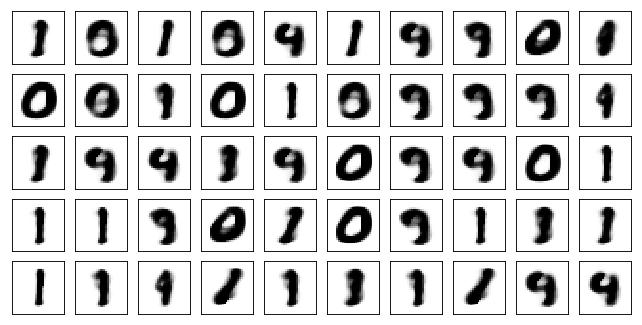

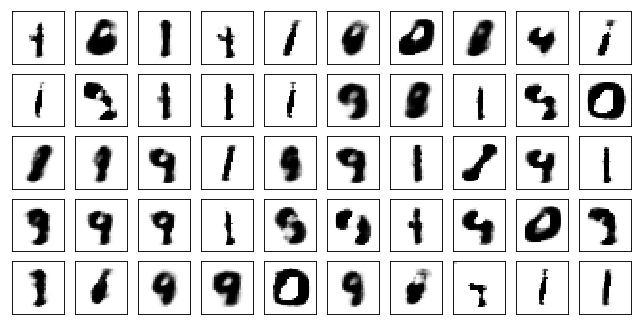

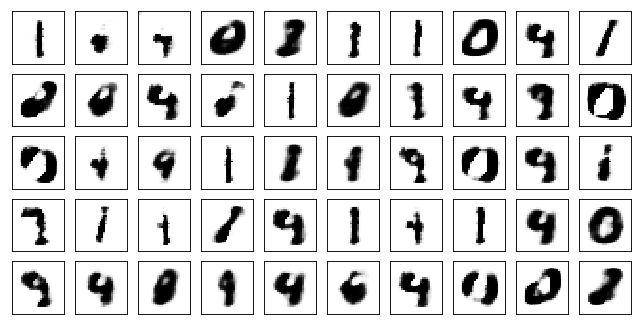

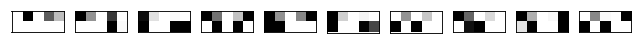

Model RMS Discr+bn+dp:


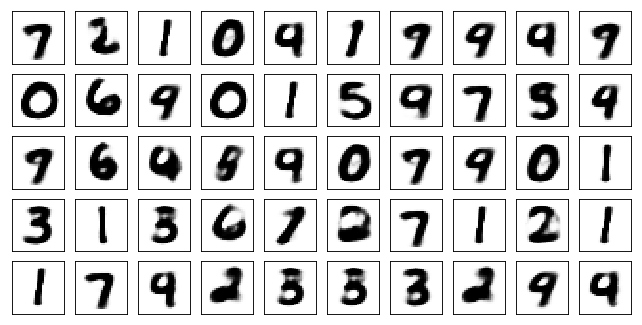

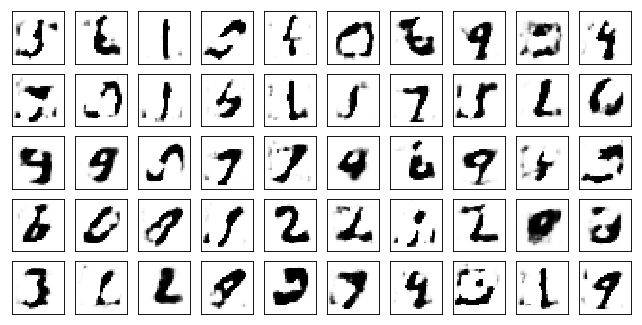

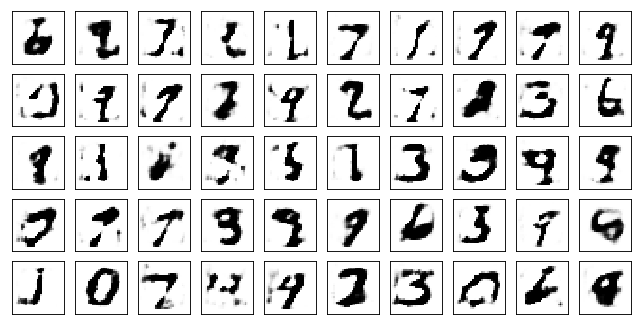

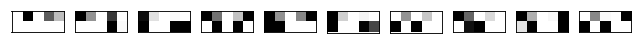

Model Adam Discr+dp:


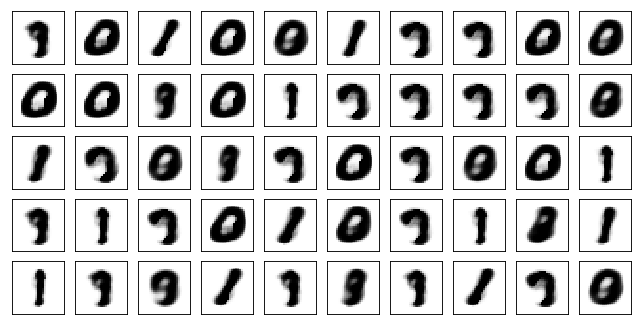

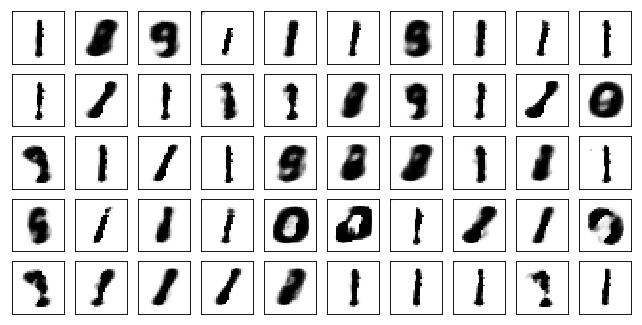

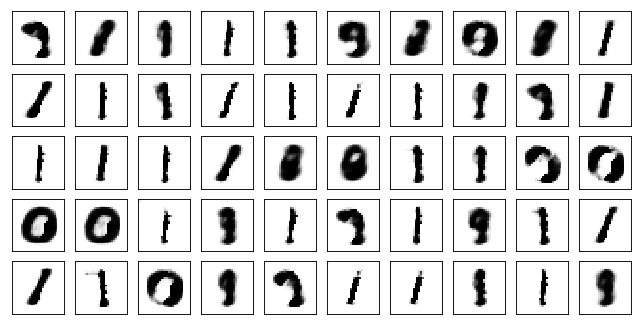

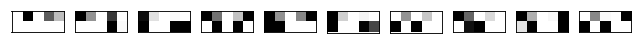

Model Adam Discr+bn+dp:


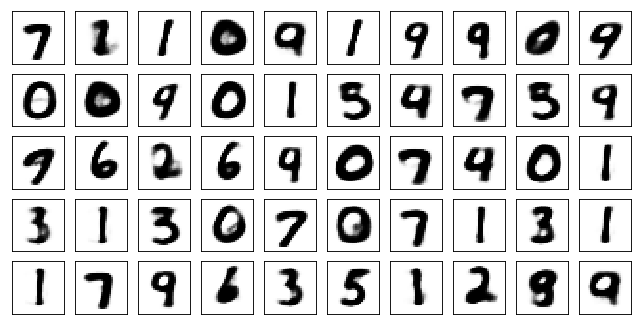

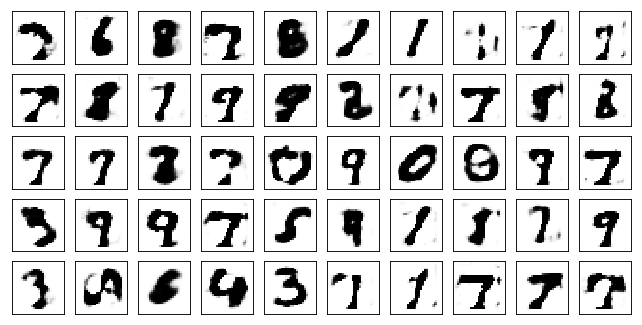

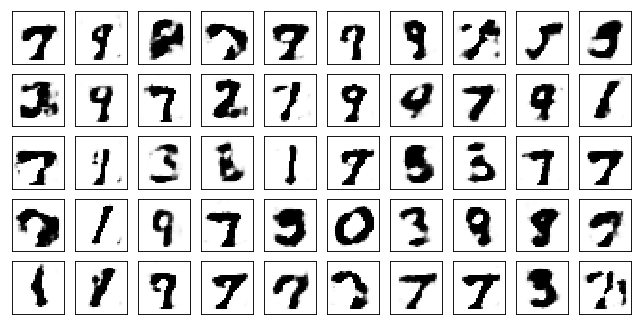

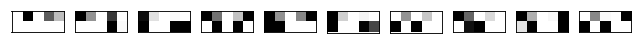

Test losses: 
RMS Discr+dp: 3.61042047 / 22.34012794 / 0.02562399 
RMS Discr+bn+dp: 3.35355258 / 31.06546783 / 0.00009908 
Adam Discr+dp: 3.69586849 / 22.22378540 / 0.02294891 
Adam Discr+bn+dp: 3.20374179 / 18.09559822 / 0.03320374 

Train Epoch: 201 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.6916 D:0.0006 RMS Discr+bn+dp: AE:6.5583 D:0.0000 Adam Discr+dp: AE:4.8385 D:0.0004 Adam Discr+bn+dp: AE:4.0775 D:0.0212
Train Epoch: 201 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.1487 D:0.0015 RMS Discr+bn+dp: AE:6.1086 D:0.0001 Adam Discr+dp: AE:4.7507 D:0.0565 Adam Discr+bn+dp: AE:3.9835 D:0.0026
Train Epoch: 201 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.4822 D:0.0015 RMS Discr+bn+dp: AE:6.6207 D:0.0000 Adam Discr+dp: AE:4.6661 D:0.0013 Adam Discr+bn+dp: AE:3.9366 D:0.0014
Test losses: 
RMS Discr+dp: 3.59036279 / 21.67116165 / 0.01812014 
RMS Discr+bn+dp: 3.34953570 / 31.33020592 / 0.00027696 
Adam Discr+dp: 3.68355846 / 22.52574348 / 0.01770368 
Adam Discr+bn+dp: 3.20194602 / 17.874336

Train Epoch: 211 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.7787 D:0.0006 RMS Discr+bn+dp: AE:6.2465 D:0.0000 Adam Discr+dp: AE:4.7252 D:0.0006 Adam Discr+bn+dp: AE:4.1837 D:0.0009
Train Epoch: 211 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.4591 D:0.0037 RMS Discr+bn+dp: AE:6.6150 D:0.0000 Adam Discr+dp: AE:4.5526 D:0.0005 Adam Discr+bn+dp: AE:4.1006 D:0.0014
Test losses: 
RMS Discr+dp: 3.60382247 / 22.64326096 / 0.01951074 
RMS Discr+bn+dp: 3.36978292 / 30.47965050 / 0.00017544 
Adam Discr+dp: 3.68944168 / 21.66408348 / 0.01940824 
Adam Discr+bn+dp: 3.22351718 / 17.45975685 / 0.02947991 

Train Epoch: 212 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.4355 D:0.0007 RMS Discr+bn+dp: AE:6.3729 D:0.0000 Adam Discr+dp: AE:4.7230 D:0.0008 Adam Discr+bn+dp: AE:4.1715 D:0.0012
Train Epoch: 212 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.6984 D:0.0023 RMS Discr+bn+dp: AE:6.0883 D:0.0000 Adam Discr+dp: AE:4.6420 D:0.0006 Adam Discr+bn+dp: AE:4.2290 D:0.0012
Train Epoch: 212 [50000/50000 (10

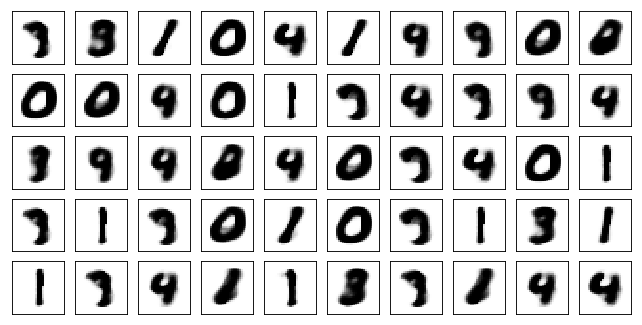

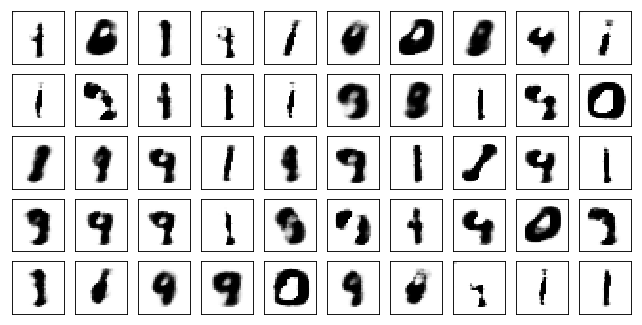

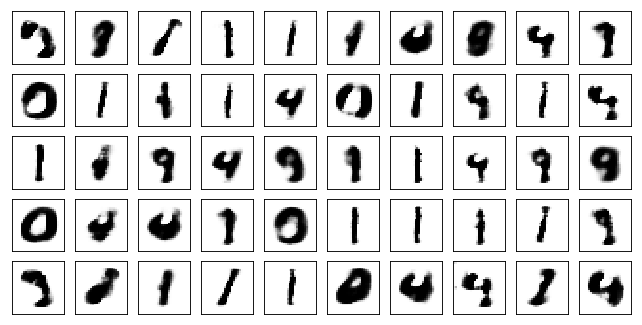

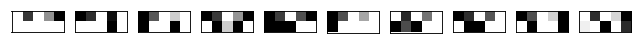

Model RMS Discr+bn+dp:


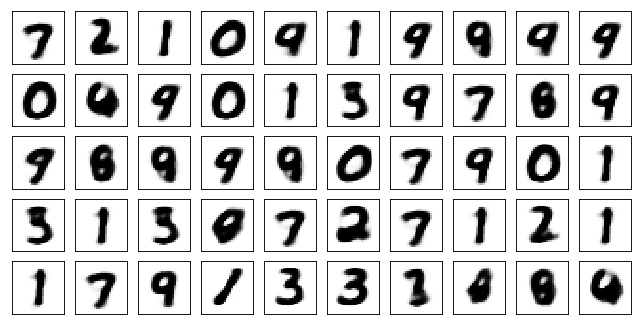

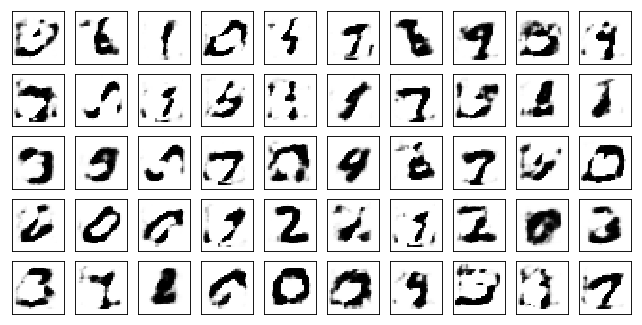

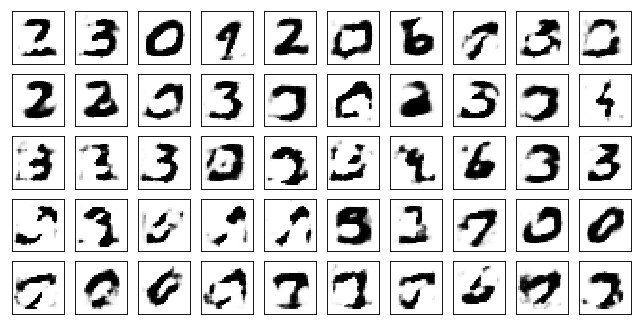

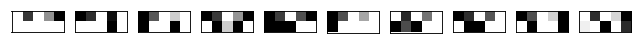

Model Adam Discr+dp:


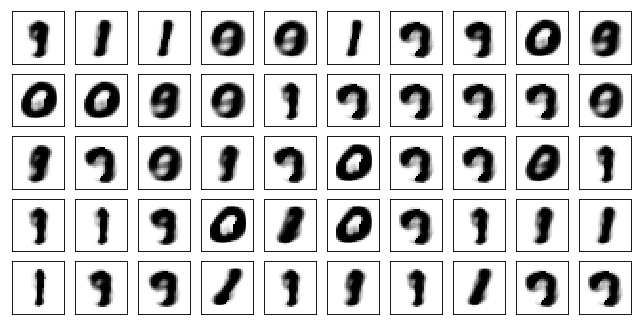

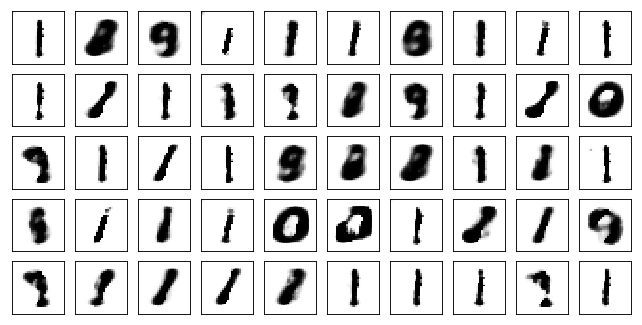

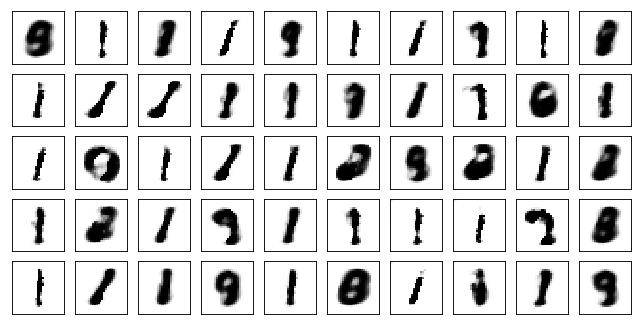

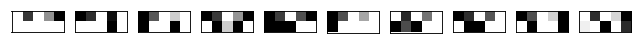

Model Adam Discr+bn+dp:


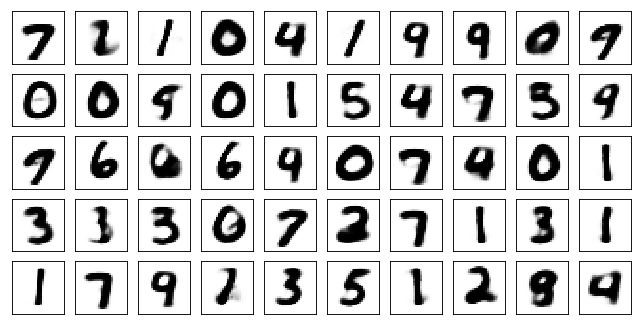

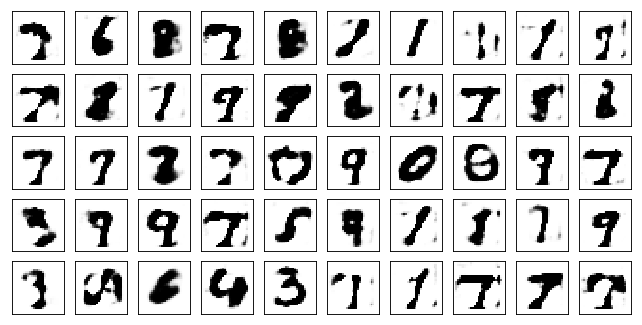

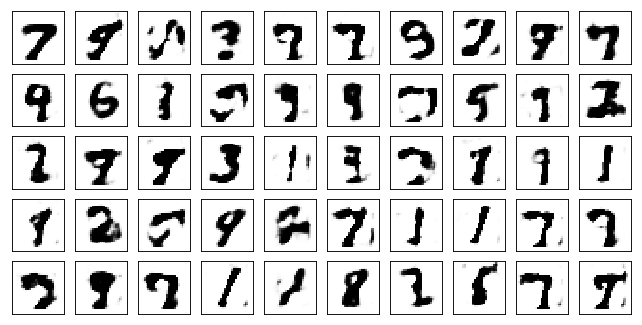

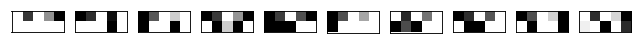

Test losses: 
RMS Discr+dp: 3.55563283 / 22.82580185 / 0.01728457 
RMS Discr+bn+dp: 3.40078259 / 28.93289757 / 0.00015601 
Adam Discr+dp: 3.64830709 / 22.17089844 / 0.01575922 
Adam Discr+bn+dp: 3.19378066 / 18.46555901 / 0.03057341 

Train Epoch: 221 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.8156 D:0.0010 RMS Discr+bn+dp: AE:6.3931 D:0.0001 Adam Discr+dp: AE:4.5656 D:0.0008 Adam Discr+bn+dp: AE:4.3535 D:0.0015
Train Epoch: 221 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.8095 D:0.0046 RMS Discr+bn+dp: AE:6.2621 D:0.0001 Adam Discr+dp: AE:4.8331 D:0.0065 Adam Discr+bn+dp: AE:4.1247 D:0.0013
Train Epoch: 221 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.8066 D:0.0005 RMS Discr+bn+dp: AE:6.3337 D:0.0000 Adam Discr+dp: AE:4.6417 D:0.0011 Adam Discr+bn+dp: AE:4.2191 D:0.0008
Test losses: 
RMS Discr+dp: 3.58620906 / 23.12482452 / 0.01397413 
RMS Discr+bn+dp: 3.42071700 / 30.24314117 / 0.00006897 
Adam Discr+dp: 3.63257265 / 23.30060768 / 0.01558550 
Adam Discr+bn+dp: 3.20265412 / 18.658382

Train Epoch: 231 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.5169 D:0.0008 RMS Discr+bn+dp: AE:6.7877 D:0.0000 Adam Discr+dp: AE:4.7737 D:0.0051 Adam Discr+bn+dp: AE:4.1393 D:0.0011
Train Epoch: 231 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.5388 D:0.0190 RMS Discr+bn+dp: AE:6.5569 D:0.0000 Adam Discr+dp: AE:4.6469 D:0.0013 Adam Discr+bn+dp: AE:4.3153 D:0.0008
Test losses: 
RMS Discr+dp: 3.63971996 / 22.03286552 / 0.01541456 
RMS Discr+bn+dp: 3.50791979 / 30.69353867 / 0.00016083 
Adam Discr+dp: 3.66733670 / 23.02889061 / 0.02086055 
Adam Discr+bn+dp: 3.19229460 / 18.84305763 / 0.02789351 

Train Epoch: 232 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.5270 D:0.0020 RMS Discr+bn+dp: AE:6.5908 D:0.0000 Adam Discr+dp: AE:4.7970 D:0.0045 Adam Discr+bn+dp: AE:4.2367 D:0.0011
Train Epoch: 232 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.4074 D:0.0007 RMS Discr+bn+dp: AE:6.6123 D:0.0000 Adam Discr+dp: AE:4.5115 D:0.0020 Adam Discr+bn+dp: AE:3.9660 D:0.0088
Train Epoch: 232 [50000/50000 (10

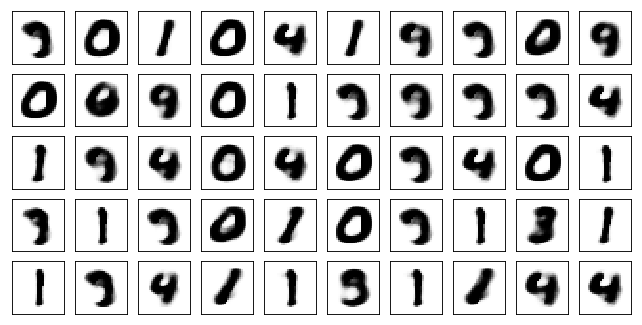

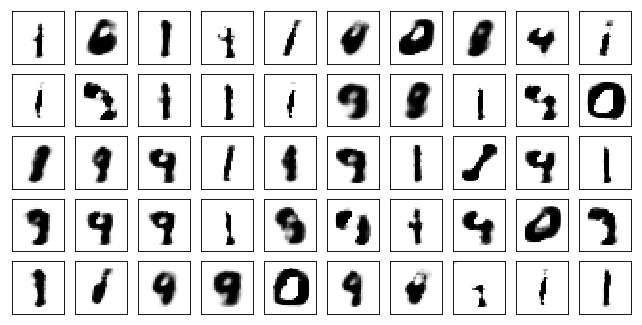

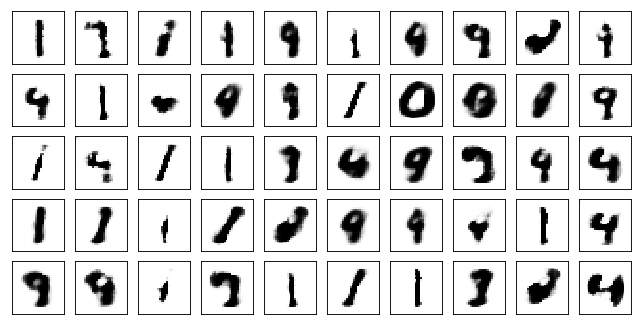

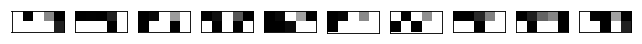

Model RMS Discr+bn+dp:


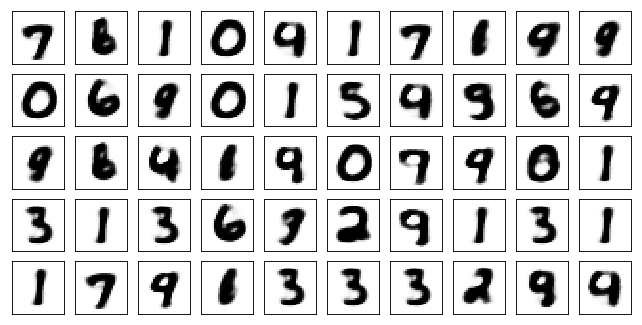

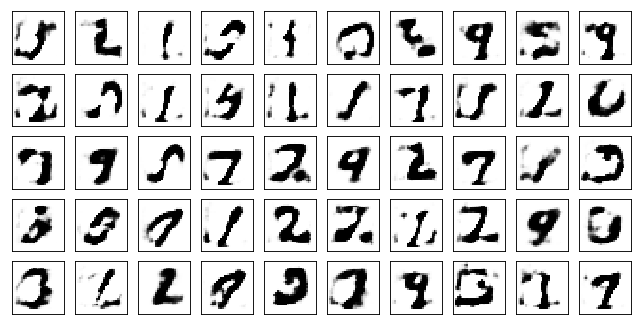

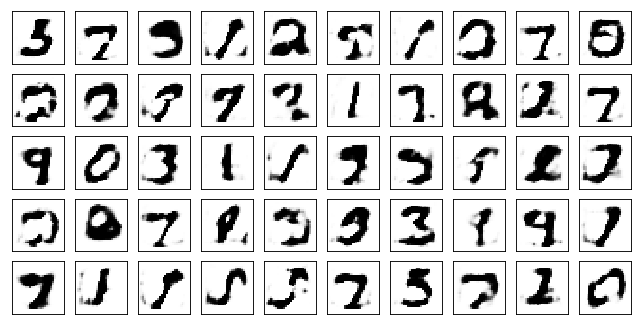

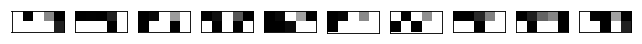

Model Adam Discr+dp:


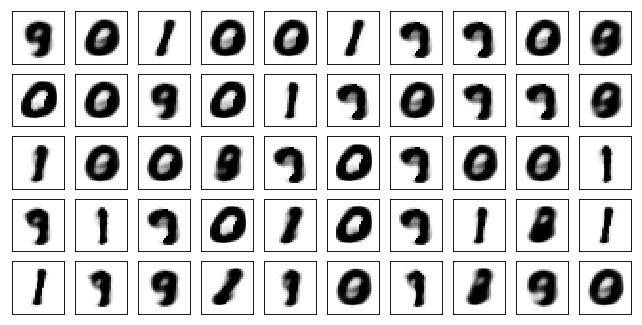

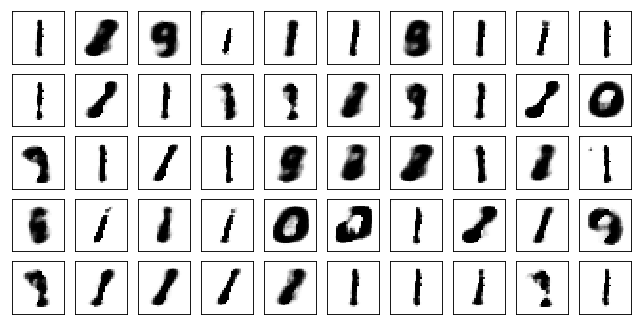

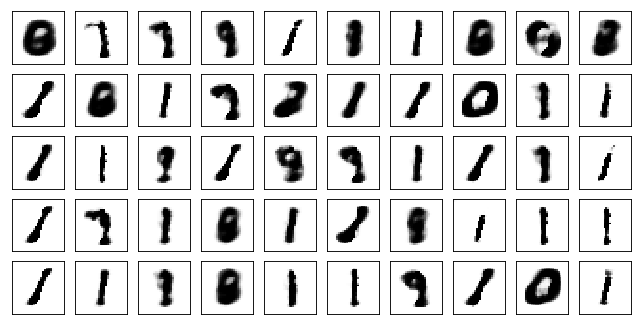

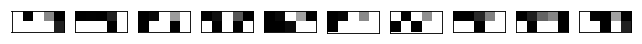

Model Adam Discr+bn+dp:


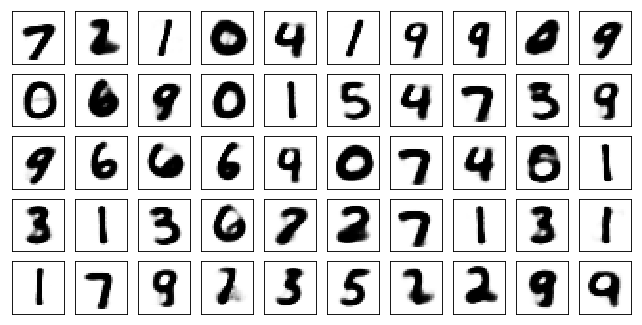

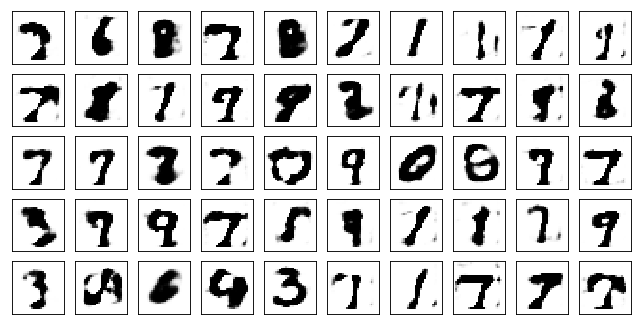

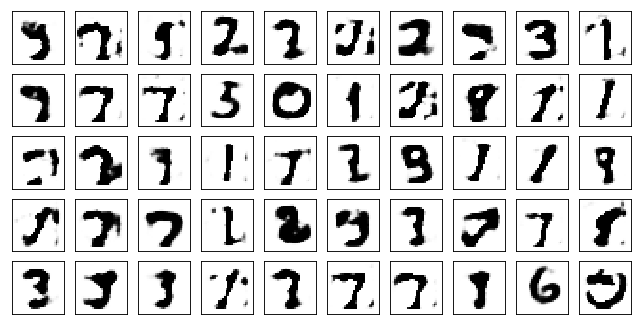

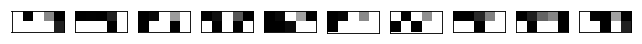

Test losses: 
RMS Discr+dp: 3.66094112 / 23.00841522 / 0.01163851 
RMS Discr+bn+dp: 3.39883566 / 31.65507698 / 0.00059278 
Adam Discr+dp: 3.69493032 / 22.86964607 / 0.01557467 
Adam Discr+bn+dp: 3.21611905 / 19.60726357 / 0.02153869 

Train Epoch: 241 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.6593 D:0.0016 RMS Discr+bn+dp: AE:6.7595 D:0.0000 Adam Discr+dp: AE:4.8183 D:0.0007 Adam Discr+bn+dp: AE:4.1692 D:0.0025
Train Epoch: 241 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.6117 D:0.0036 RMS Discr+bn+dp: AE:6.5411 D:0.0000 Adam Discr+dp: AE:4.6179 D:0.0048 Adam Discr+bn+dp: AE:4.2578 D:0.0021
Train Epoch: 241 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.7392 D:0.0024 RMS Discr+bn+dp: AE:6.3233 D:0.0000 Adam Discr+dp: AE:4.9527 D:0.0005 Adam Discr+bn+dp: AE:3.8852 D:0.0015
Test losses: 
RMS Discr+dp: 3.69525027 / 23.25602531 / 0.01657819 
RMS Discr+bn+dp: 3.43476462 / 30.61223030 / 0.00005362 
Adam Discr+dp: 3.75905609 / 24.36862755 / 0.01625552 
Adam Discr+bn+dp: 3.19540620 / 17.951553

Train Epoch: 251 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.8128 D:0.0014 RMS Discr+bn+dp: AE:6.6249 D:0.0000 Adam Discr+dp: AE:4.5451 D:0.0006 Adam Discr+bn+dp: AE:4.3357 D:0.0008
Train Epoch: 251 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.9103 D:0.0003 RMS Discr+bn+dp: AE:7.0575 D:0.0000 Adam Discr+dp: AE:4.7928 D:0.0016 Adam Discr+bn+dp: AE:4.3444 D:0.0011
Test losses: 
RMS Discr+dp: 3.59629941 / 23.72633743 / 0.01362351 
RMS Discr+bn+dp: 3.40053248 / 33.19157028 / 0.00006018 
Adam Discr+dp: 3.69028401 / 24.08606911 / 0.01290121 
Adam Discr+bn+dp: 3.19833207 / 20.09643364 / 0.02620617 

Train Epoch: 252 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.8808 D:0.0009 RMS Discr+bn+dp: AE:7.1734 D:0.0000 Adam Discr+dp: AE:5.0139 D:0.0112 Adam Discr+bn+dp: AE:4.3920 D:0.0005
Train Epoch: 252 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.7905 D:0.0006 RMS Discr+bn+dp: AE:6.9428 D:0.0000 Adam Discr+dp: AE:4.9371 D:0.0003 Adam Discr+bn+dp: AE:4.2474 D:0.0033
Train Epoch: 252 [50000/50000 (10

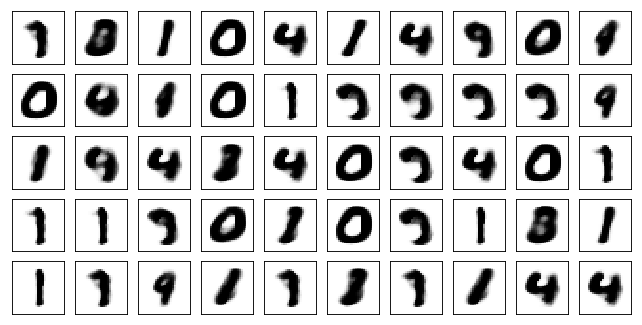

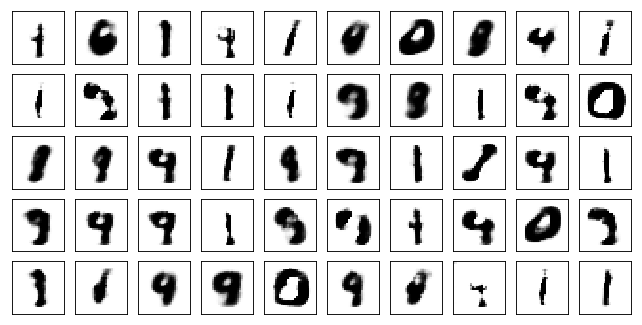

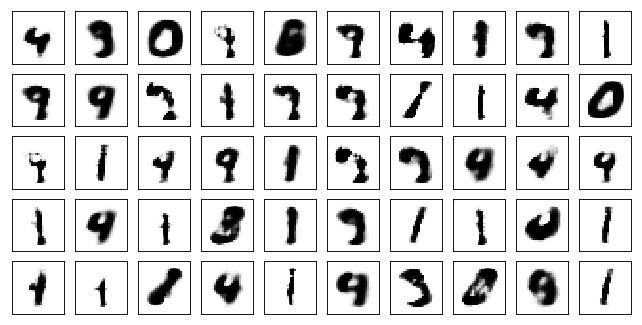

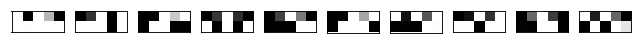

Model RMS Discr+bn+dp:


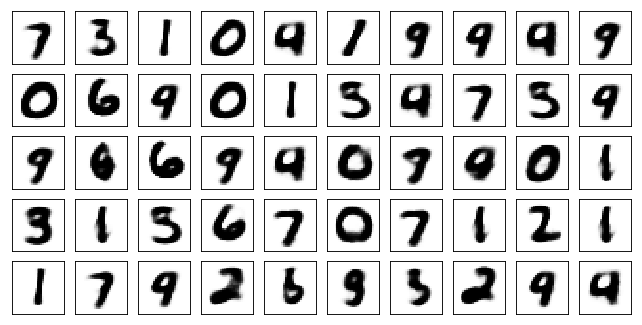

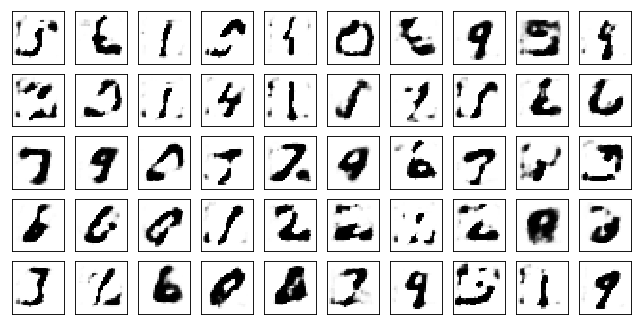

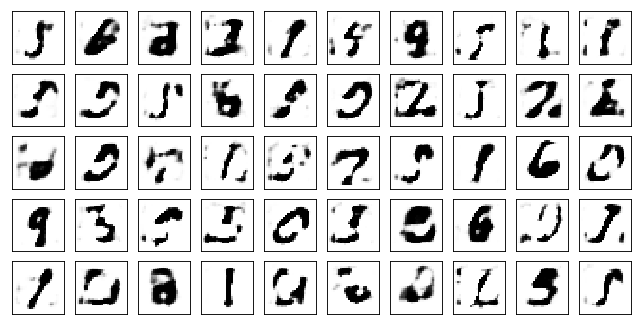

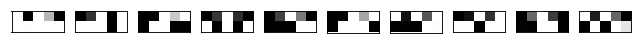

Model Adam Discr+dp:


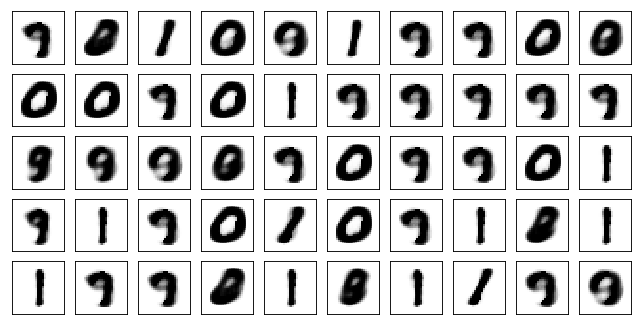

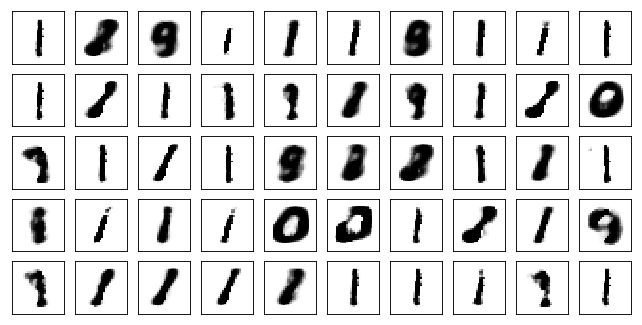

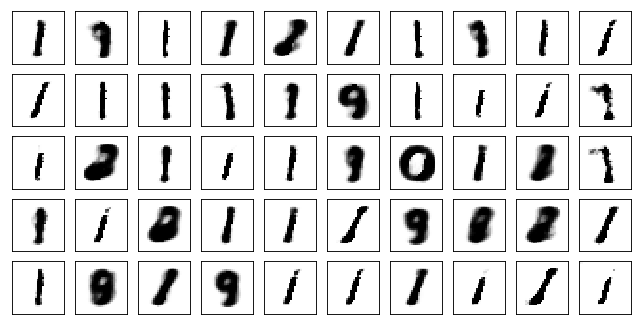

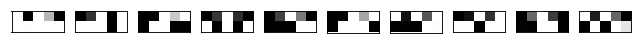

Model Adam Discr+bn+dp:


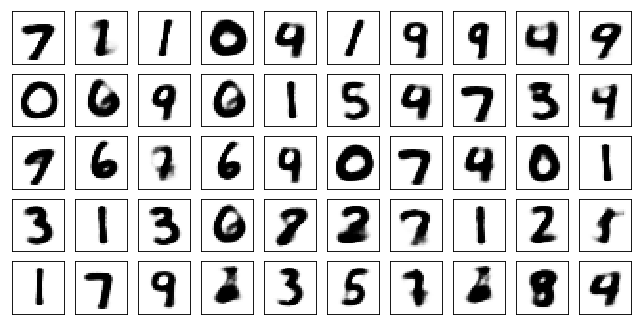

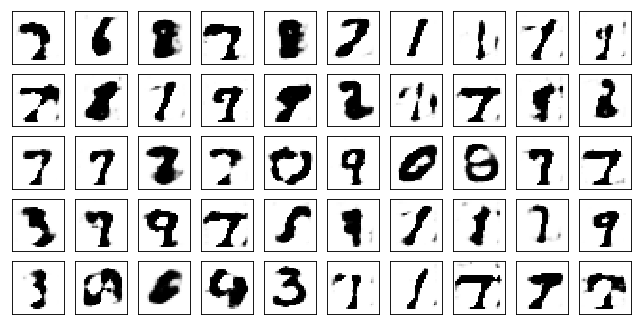

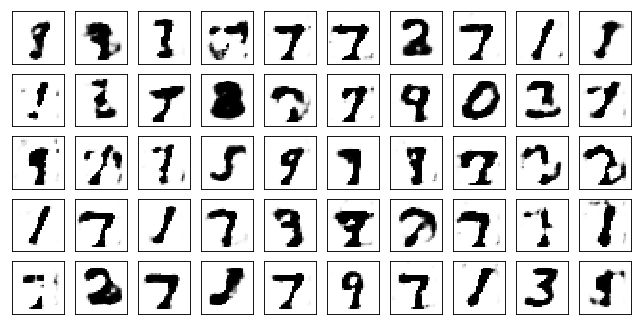

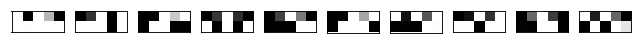

Test losses: 
RMS Discr+dp: 3.61927152 / 25.02659035 / 0.01066545 
RMS Discr+bn+dp: 3.37890983 / 31.93226433 / 0.00036530 
Adam Discr+dp: 3.69112515 / 23.75176048 / 0.01354941 
Adam Discr+bn+dp: 3.18747330 / 19.74734497 / 0.02511009 

Train Epoch: 261 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.9585 D:0.0005 RMS Discr+bn+dp: AE:6.8477 D:0.0000 Adam Discr+dp: AE:4.6339 D:0.0007 Adam Discr+bn+dp: AE:4.3436 D:0.0014
Train Epoch: 261 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.8885 D:0.0014 RMS Discr+bn+dp: AE:7.0549 D:0.0000 Adam Discr+dp: AE:4.7856 D:0.0009 Adam Discr+bn+dp: AE:4.0007 D:0.0026
Train Epoch: 261 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.9610 D:0.0001 RMS Discr+bn+dp: AE:6.9134 D:0.0000 Adam Discr+dp: AE:4.7373 D:0.0005 Adam Discr+bn+dp: AE:4.2012 D:0.0011
Test losses: 
RMS Discr+dp: 3.59727359 / 25.44504166 / 0.01225211 
RMS Discr+bn+dp: 3.36571717 / 32.30109787 / 0.00000760 
Adam Discr+dp: 3.70739222 / 24.45318604 / 0.01321543 
Adam Discr+bn+dp: 3.19488692 / 19.454822

Train Epoch: 271 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:5.1351 D:0.0004 RMS Discr+bn+dp: AE:6.8783 D:0.0000 Adam Discr+dp: AE:4.9605 D:0.0030 Adam Discr+bn+dp: AE:4.1991 D:0.0011
Train Epoch: 271 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.6977 D:0.0248 RMS Discr+bn+dp: AE:7.0273 D:0.0000 Adam Discr+dp: AE:5.1121 D:0.0011 Adam Discr+bn+dp: AE:3.9700 D:0.0438
Test losses: 
RMS Discr+dp: 3.59974003 / 24.31406593 / 0.01092613 
RMS Discr+bn+dp: 3.42422366 / 32.84524155 / 0.00087666 
Adam Discr+dp: 3.61958361 / 26.06540680 / 0.01106017 
Adam Discr+bn+dp: 3.19659138 / 19.02816772 / 0.02320375 

Train Epoch: 272 [0/50000 (0%)]	Losses RMS Discr+dp: AE:4.8740 D:0.0005 RMS Discr+bn+dp: AE:6.8853 D:0.0000 Adam Discr+dp: AE:5.2548 D:0.0019 Adam Discr+bn+dp: AE:4.2748 D:0.0015
Train Epoch: 272 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:5.0041 D:0.0003 RMS Discr+bn+dp: AE:7.1407 D:0.0000 Adam Discr+dp: AE:4.8642 D:0.0005 Adam Discr+bn+dp: AE:4.3148 D:0.0020
Train Epoch: 272 [50000/50000 (10

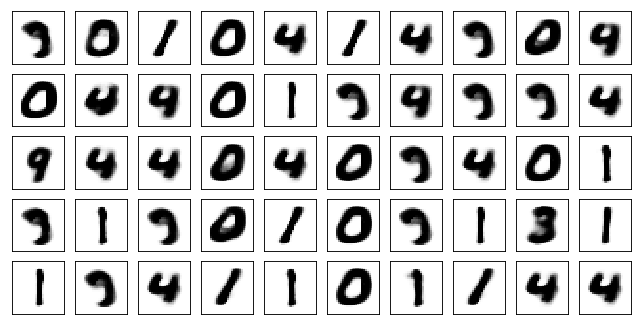

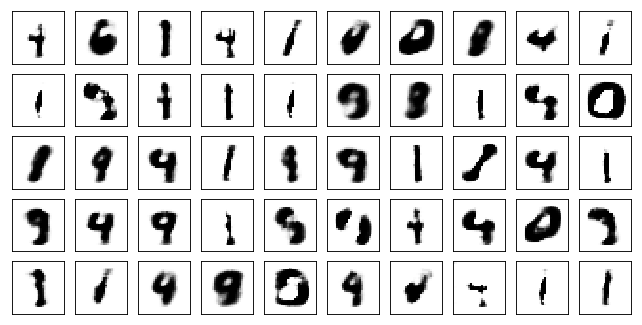

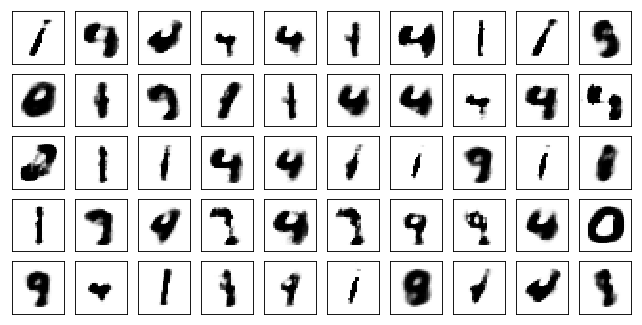

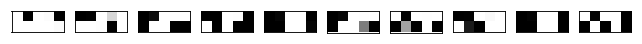

Model RMS Discr+bn+dp:


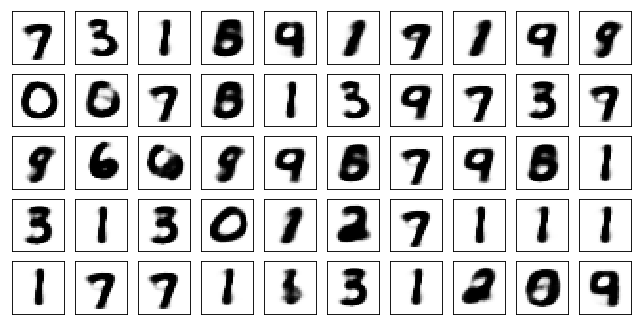

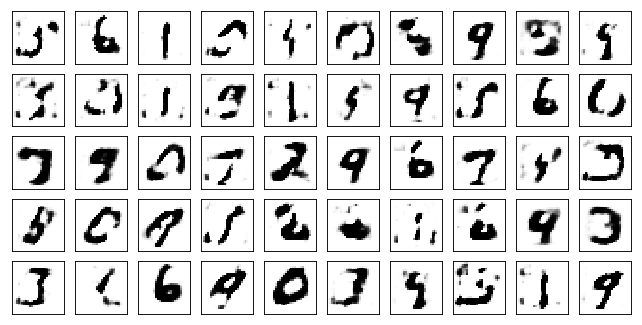

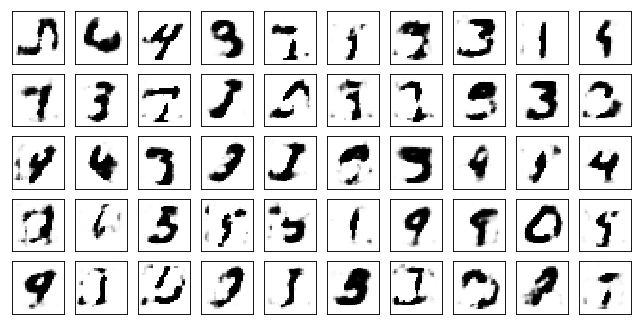

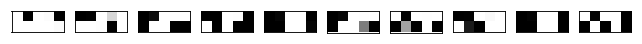

Model Adam Discr+dp:


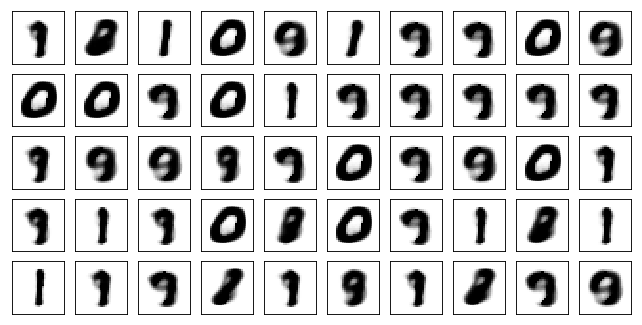

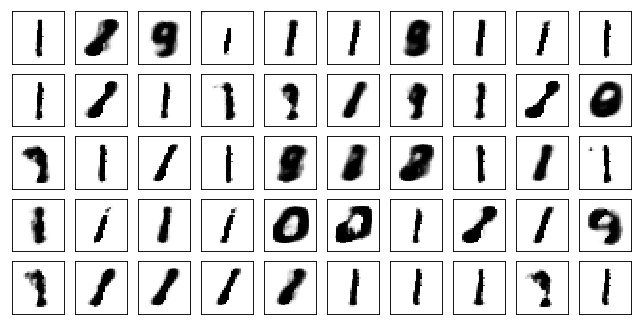

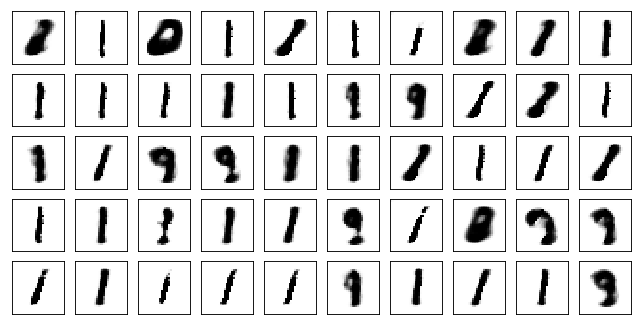

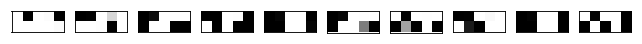

Model Adam Discr+bn+dp:


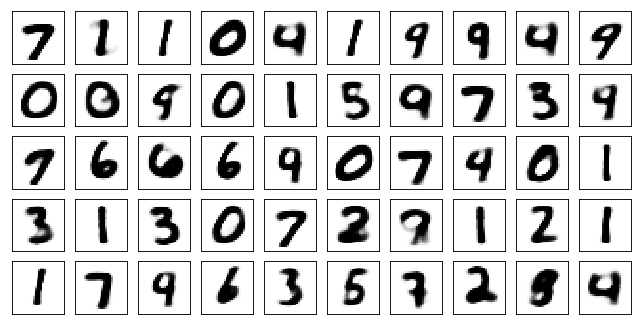

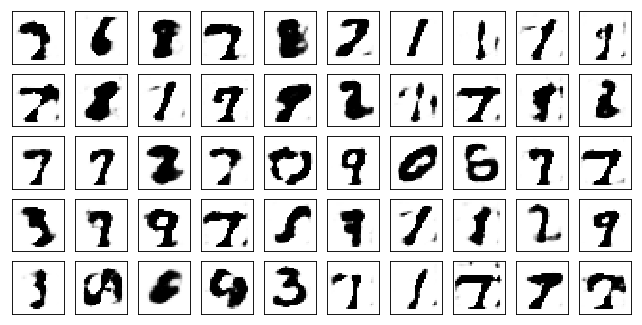

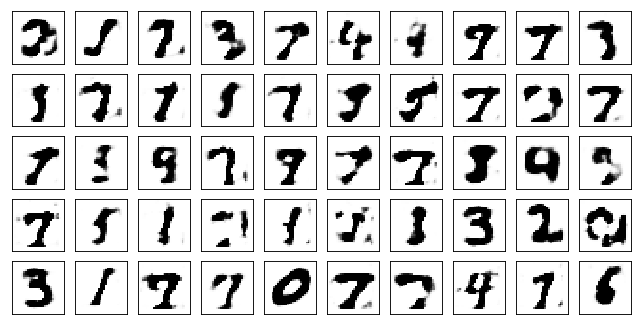

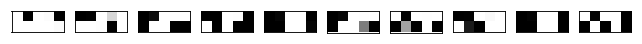

Test losses: 
RMS Discr+dp: 3.59815454 / 25.80001068 / 0.01253888 
RMS Discr+bn+dp: 3.44752884 / 31.71203613 / 0.00019159 
Adam Discr+dp: 3.70395160 / 25.47808838 / 0.01181654 
Adam Discr+bn+dp: 3.19553399 / 23.06803131 / 0.01909848 

Train Epoch: 281 [0/50000 (0%)]	Losses RMS Discr+dp: AE:5.2152 D:0.0006 RMS Discr+bn+dp: AE:6.7396 D:0.0000 Adam Discr+dp: AE:5.0738 D:0.0003 Adam Discr+bn+dp: AE:4.5907 D:0.0004
Train Epoch: 281 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:4.9362 D:0.0003 RMS Discr+bn+dp: AE:6.3710 D:0.0000 Adam Discr+dp: AE:5.2580 D:0.0003 Adam Discr+bn+dp: AE:4.4372 D:0.0009
Train Epoch: 281 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:4.7007 D:0.0012 RMS Discr+bn+dp: AE:6.3816 D:0.0001 Adam Discr+dp: AE:4.6625 D:0.0015 Adam Discr+bn+dp: AE:4.1038 D:0.0013
Test losses: 
RMS Discr+dp: 3.62470961 / 23.44500351 / 0.01103697 
RMS Discr+bn+dp: 3.45667744 / 29.88633156 / 0.00096596 
Adam Discr+dp: 3.72644186 / 24.89332771 / 0.00932518 
Adam Discr+bn+dp: 3.19567990 / 19.835096

Train Epoch: 291 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:5.3007 D:0.0007 RMS Discr+bn+dp: AE:6.4252 D:0.0000 Adam Discr+dp: AE:4.9204 D:0.0019 Adam Discr+bn+dp: AE:4.0117 D:0.0020
Train Epoch: 291 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:5.1052 D:0.0228 RMS Discr+bn+dp: AE:6.7007 D:0.0000 Adam Discr+dp: AE:5.0203 D:0.0002 Adam Discr+bn+dp: AE:4.1211 D:0.0011
Test losses: 
RMS Discr+dp: 3.62890506 / 26.11257553 / 0.01183165 
RMS Discr+bn+dp: 3.39362907 / 31.83333015 / 0.00048440 
Adam Discr+dp: 3.73755169 / 25.06089592 / 0.00788978 
Adam Discr+bn+dp: 3.18447781 / 19.97553825 / 0.01778725 

Train Epoch: 292 [0/50000 (0%)]	Losses RMS Discr+dp: AE:5.0477 D:0.0007 RMS Discr+bn+dp: AE:6.7217 D:0.0000 Adam Discr+dp: AE:4.8228 D:0.0004 Adam Discr+bn+dp: AE:4.2301 D:0.0013
Train Epoch: 292 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:5.1099 D:0.0008 RMS Discr+bn+dp: AE:6.8243 D:0.0000 Adam Discr+dp: AE:5.4022 D:0.0003 Adam Discr+bn+dp: AE:4.2971 D:0.0008
Train Epoch: 292 [50000/50000 (10

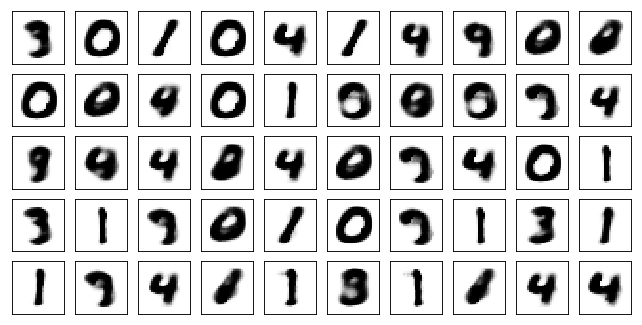

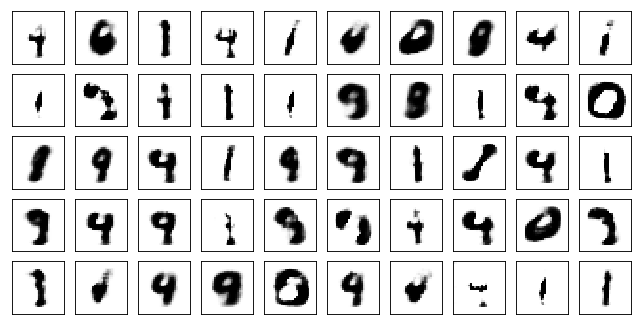

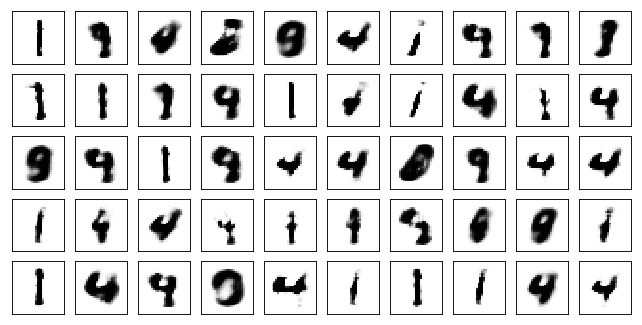

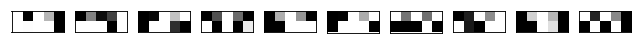

Model RMS Discr+bn+dp:


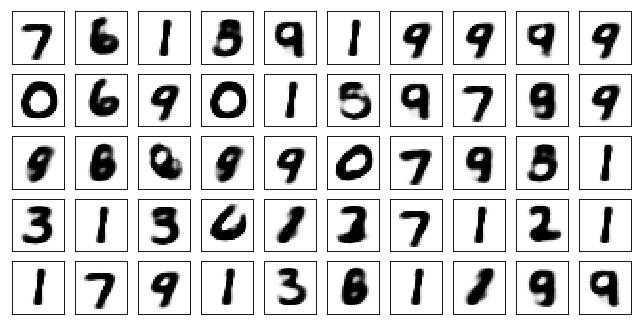

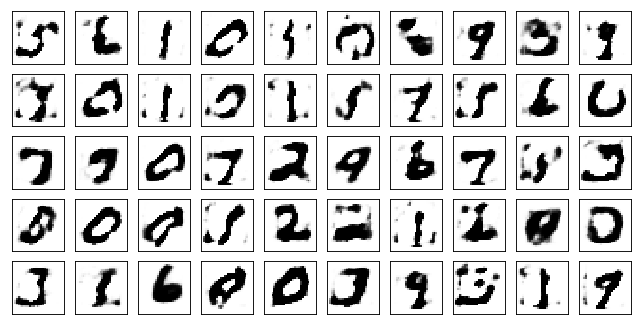

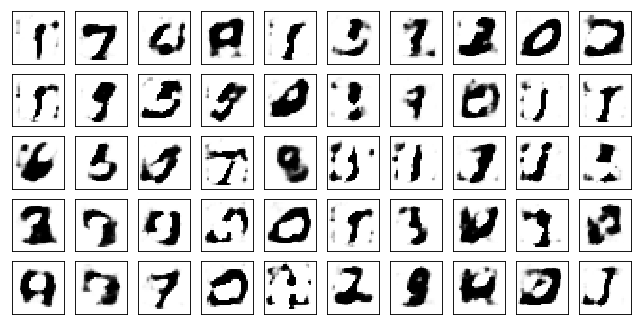

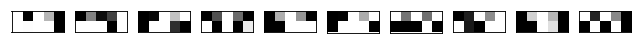

Model Adam Discr+dp:


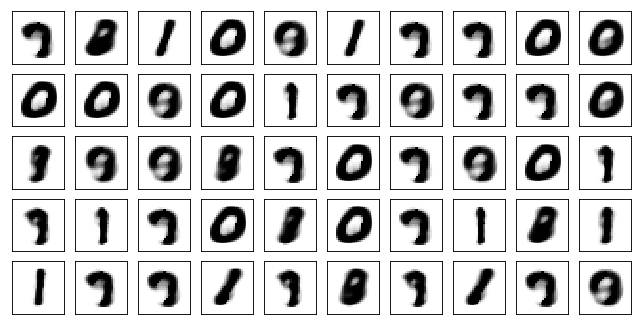

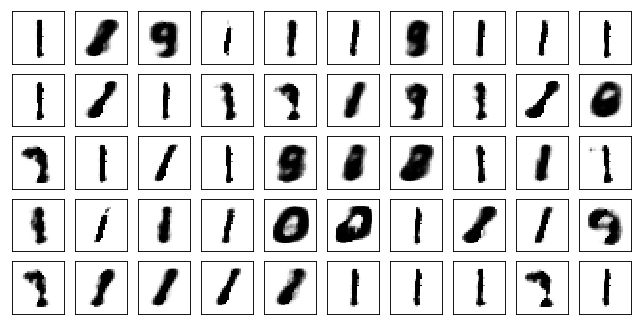

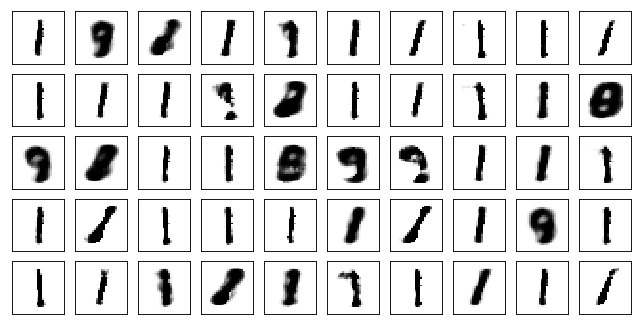

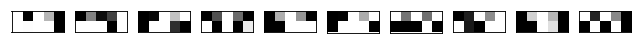

Model Adam Discr+bn+dp:


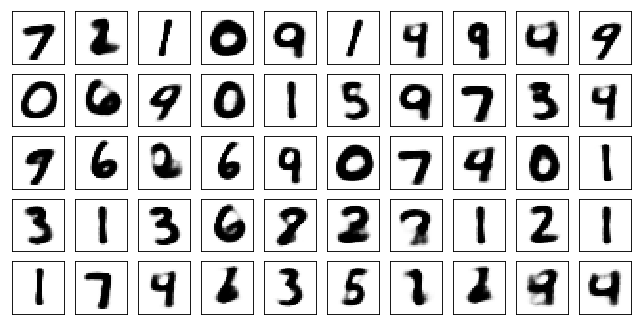

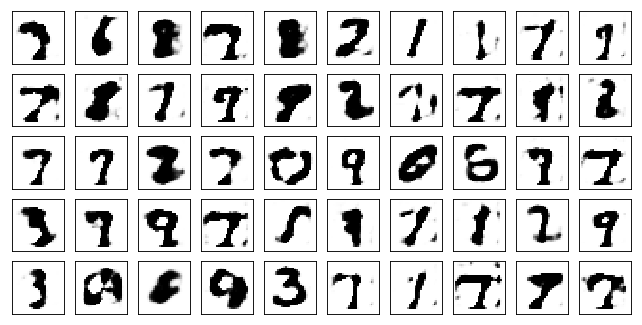

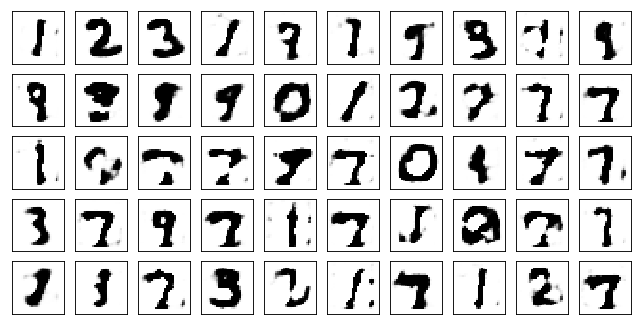

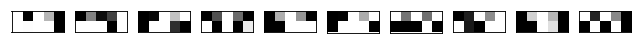

Test losses: 
RMS Discr+dp: 3.60908413 / 25.67430305 / 0.01256829 
RMS Discr+bn+dp: 3.40227437 / 32.93498230 / 0.00001361 
Adam Discr+dp: 3.71727681 / 25.84478760 / 0.01209535 
Adam Discr+bn+dp: 3.17937589 / 19.41071510 / 0.01995964 

Train Epoch: 301 [0/50000 (0%)]	Losses RMS Discr+dp: AE:5.2514 D:0.0003 RMS Discr+bn+dp: AE:7.1343 D:0.0000 Adam Discr+dp: AE:4.8651 D:0.0003 Adam Discr+bn+dp: AE:4.2548 D:0.0011
Train Epoch: 301 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:5.0152 D:0.0013 RMS Discr+bn+dp: AE:6.2564 D:0.0000 Adam Discr+dp: AE:5.0824 D:0.0002 Adam Discr+bn+dp: AE:4.3622 D:0.0013
Train Epoch: 301 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:5.2101 D:0.0003 RMS Discr+bn+dp: AE:6.8328 D:0.0000 Adam Discr+dp: AE:5.4222 D:0.0019 Adam Discr+bn+dp: AE:4.4463 D:0.0009
Test losses: 
RMS Discr+dp: 3.61980391 / 26.59336853 / 0.00990380 
RMS Discr+bn+dp: 3.39452028 / 32.89455795 / 0.00033491 
Adam Discr+dp: 3.72814345 / 26.16606712 / 0.01103461 
Adam Discr+bn+dp: 3.18241358 / 21.213066

Train Epoch: 311 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:5.0575 D:0.0004 RMS Discr+bn+dp: AE:6.9163 D:0.0000 Adam Discr+dp: AE:5.1045 D:0.0071 Adam Discr+bn+dp: AE:4.2001 D:0.0006
Train Epoch: 311 [50000/50000 (100%)]	Losses RMS Discr+dp: AE:5.3367 D:0.0002 RMS Discr+bn+dp: AE:6.3614 D:0.0000 Adam Discr+dp: AE:5.1807 D:0.0011 Adam Discr+bn+dp: AE:4.3883 D:0.0005
Test losses: 
RMS Discr+dp: 3.67464447 / 26.59383011 / 0.01264031 
RMS Discr+bn+dp: 3.46148515 / 29.85976791 / 0.00002699 
Adam Discr+dp: 3.67373681 / 27.39459610 / 0.01041446 
Adam Discr+bn+dp: 3.18077517 / 20.32514763 / 0.02129693 

Train Epoch: 312 [0/50000 (0%)]	Losses RMS Discr+dp: AE:5.2428 D:0.0187 RMS Discr+bn+dp: AE:6.2045 D:0.0000 Adam Discr+dp: AE:5.1920 D:0.0006 Adam Discr+bn+dp: AE:4.3389 D:0.0008
Train Epoch: 312 [25000/50000 (50%)]	Losses RMS Discr+dp: AE:5.0014 D:0.0004 RMS Discr+bn+dp: AE:6.6847 D:0.0000 Adam Discr+dp: AE:5.2490 D:0.0011 Adam Discr+bn+dp: AE:3.9237 D:0.0010
Train Epoch: 312 [50000/50000 (10

KeyboardInterrupt: 

In [17]:
for epoch in range(1, train_epoch):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, 20, test_log)

Model RMS Discr+dp:


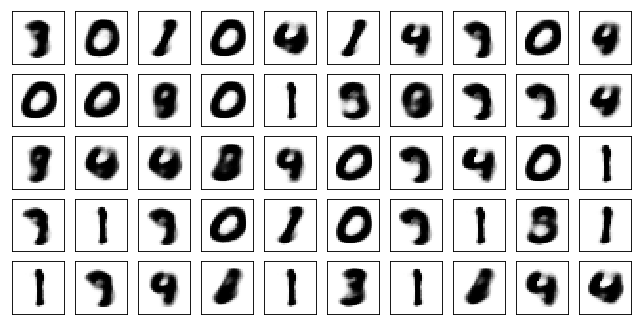

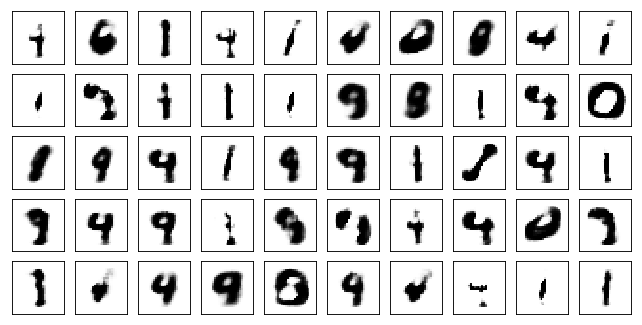

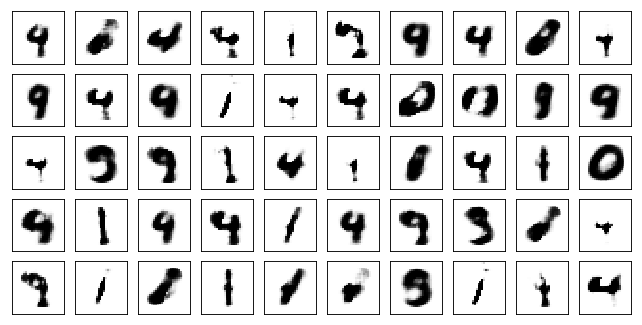

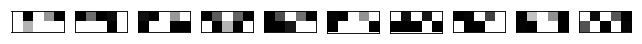

Model RMS Discr+bn+dp:


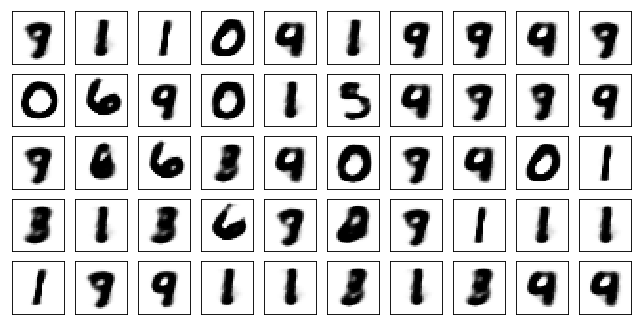

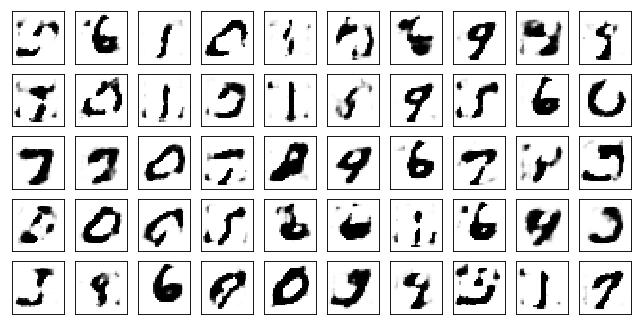

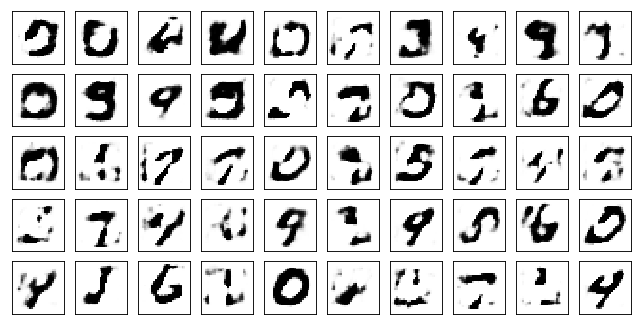

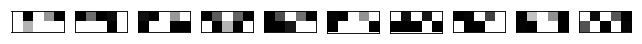

Model Adam Discr+dp:


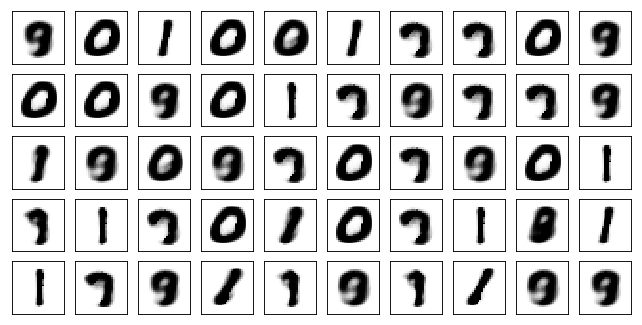

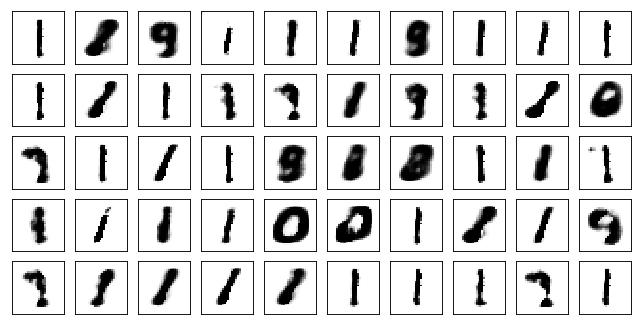

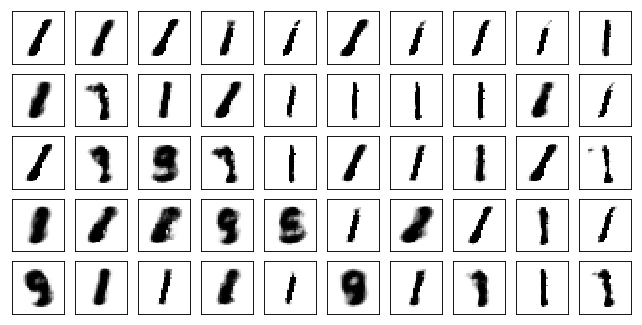

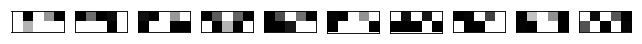

Model Adam Discr+bn+dp:


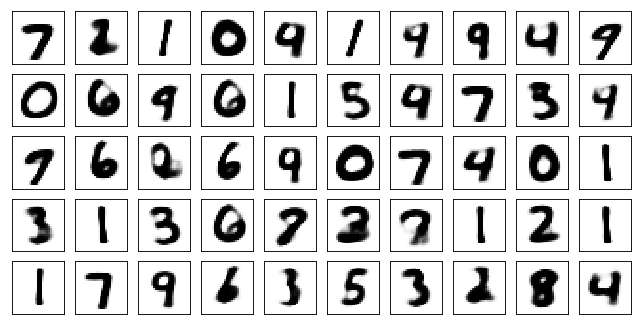

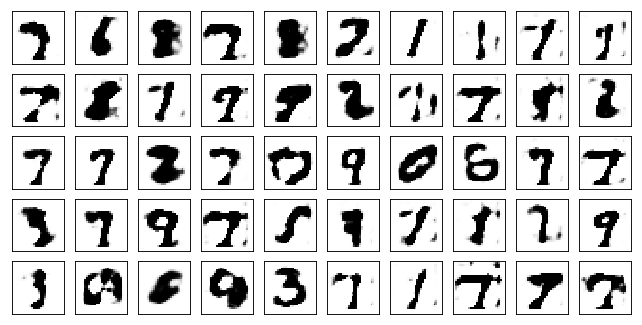

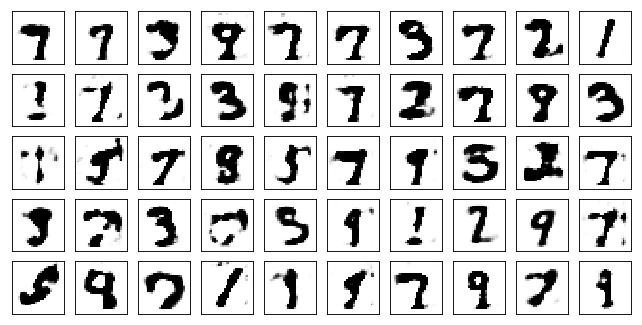

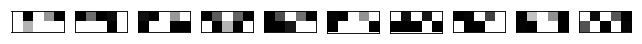

Test losses: 
RMS Discr+dp: 3.60953999 / 26.31511497 / 0.00842896 
RMS Discr+bn+dp: 3.50967860 / 30.37663078 / 0.00046762 
Adam Discr+dp: 3.71767044 / 26.31274605 / 0.01046431 
Adam Discr+bn+dp: 3.17791462 / 20.77429581 / 0.02138852 



In [19]:
for model in models.values():
    model.eval()
test(models, valid_loader, 1, 1, test_log)

In [20]:
torch.save(models['RMS Discr+dp'], './rms_ds_dp_l10_3')
torch.save(models['RMS Discr+bn+dp'], './rms_ds_bndp_l10_3')
torch.save(models['Adam Discr+dp'], './adam_ds_dp_l10_3')
torch.save(models['Adam Discr+bn+dp'], './adam_ds_bndp_l10_3')

/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Deconv

### Вывод результатов

In [21]:
model = torch.load('./adam_ds_bndp_l10_3')

In [22]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).cpu().data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    enc_to_lot = encoded.view(-1, 1, 2, 5).clamp(0, 1).cpu().data.numpy()
    print ('enc=', encoded.shape)


enc= torch.Size([50, 10])


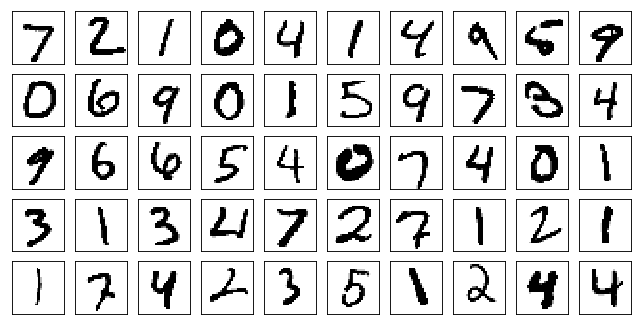

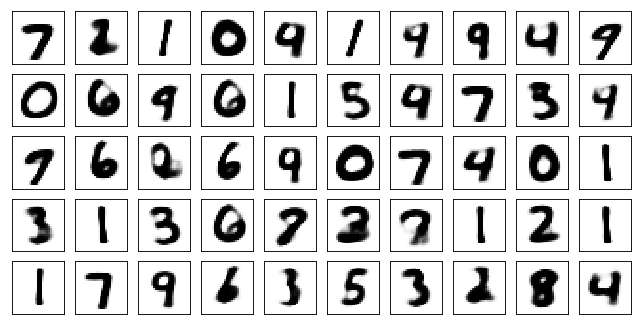

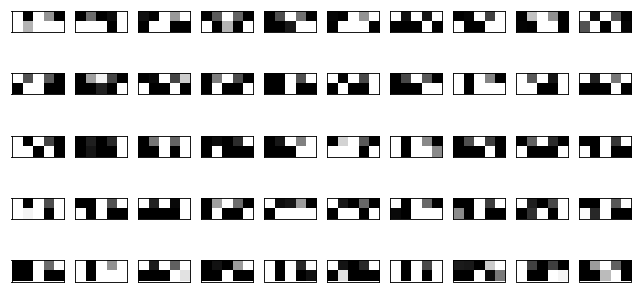

In [23]:
plot_mnist(data.data.clamp(0, 1).cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_latent(enc_to_lot, (5, 10))

In [24]:
def show_generated_samples():
    pred_z = torch.randn((50, 10)).to(device)
       
    pred_gen = model.decode(pred_z)
    generated = pred_gen.view(-1, 1, 28, 28).clamp(0, 1).cpu().data.numpy()  
    plot_mnist(generated, (5, 10))

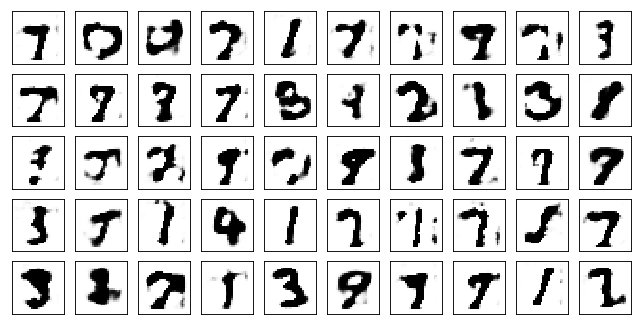

In [25]:
show_generated_samples()